# Global Imports

In [1]:
# https://www.kaggle.com/code/viveksrinivasan/zillow-eda-on-missing-values-multicollinearity

import time
import json
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn
# for visualizing missing values
import missingno as msno

# for display plot inline
%matplotlib inline
# change the style
matplotlib.style.use('ggplot')

# Reading Dataset

The Toronto Real Estate Board (TREB) database has data coverted a large regions, not just Toronto. Here is our criteria when downloading data from TREB database:
- property type: Residential/Condo
  - residential and condo have different fields/features:
    - house has lot_size, pool, garage, etc.
    - condo has apartment number, locker, condo fee, pet permission, etc.
- sold price: >= 0
  - Some listings may have sold price 0, 1, 10, we try to exlude these outliers.
- type: 'Sale'
  - exlucde rental listings
- area in ["Toronto", "York", "Simcoe", "Peel", "Halton", "Durham", "Dufferin"]
  - Although TREB has listings outside of Toronto, but agents may prefer list on the local boards. These areas are covered in the TREB report: https://trreb.ca/files/market-stats/market-watch/mw2403.pdf 
  - We will focus on these areas. Other areas may not have enough data to train.
- sold date
  - each csv file contains listings sold within that year (e.g. 2023_Residential.csv contains listings that sold within year 2023)
- sort by sold date
  - the dataset is sorted by sold date

In [2]:
# data criteria:
# 10 <= Sp_dol
# 2023-01-01 <= Cd <= 2023-12-31
# S_r = 'Sale'
# Area in ["Toronto", "York", "Simcoe", "Peel", "Halton", "Durham", "Dufferin"]
# sort by Cd desc

data_res = pd.read_csv('../../data/original/mls/2023_Residential.csv')
data_res.set_index('Ml_num', inplace = True)

data_con = pd.read_csv('../../data/original/mls/2023_Condo.csv')
data_con.set_index('Ml_num', inplace = True)

data_res = data_res.sort_values(by='Cd',ascending=False)
data_con = data_con.sort_values(by='Cd',ascending=False)



# In TREB, some categorical features have a fixed set of values
with open("../../data/residential_metadata.json", "r") as f:
    metadata_res = json.loads(f.read())
    
with open("../../data/condo_metadata.json", "r") as f:
    metadata_con = json.loads(f.read())

C:\Users\Frank\AppData\Local\Temp\ipykernel_37772\1442193846.py:8: DtypeWarning: Columns (0,10,11,17,18,19,21,22,27,30,31,32,37,38,40,43,64,77,78,80,105,109,194,195,218,245,253,257,260,266,271,273,274,275,282,291,293,294,295,298,299,300,301,302,303,304,305,306,307,308,309,310,311,312,313) have mixed types. Specify dtype option on import or set low_memory=False.
  data_res = pd.read_csv('../../data/original/mls/2023_Residential.csv')
C:\Users\Frank\AppData\Local\Temp\ipykernel_37772\1442193846.py:11: DtypeWarning: Columns (0,48,52,53,54,55,56,59,61,62,85,87,88,89,91,92,93,94,145,148,176,232,258,259,262,263,265,266,276,277,280,282,287,308,309) have mixed types. Specify dtype option on import or set low_memory=False.
  data_con = pd.read_csv('../../data/original/mls/2023_Condo.csv')


# Data Prepocessing

## Display First few Rows of Data

In [3]:
pd.set_option('display.max_rows', None)
data_res.head(3).transpose()
# pd.reset_option('display.max_rows')

Ml_num,N7251618,N7263020,N7371576
Heat_inc,NaN,NaN,NaN
Rm11_out,NaN,NaN,NaN
Rm7_dc3_out,NaN,NaN,NaN
Spec_des6_out,NaN,NaN,NaN
Wcloset_t1,1.0,1.0,1.0
Water_body,NaN,NaN,NaN
Water_type,NaN,NaN,NaN
Water_front,NaN,NaN,NaN
Access_prop1,NaN,NaN,NaN
Easement_rest1,NaN,NaN,NaN


## Data Types

In [4]:
# reset_index() for converting index to integer 0,1,2... 
# to check original index: pd.DataFrame(data_res_sorted.dtypes.value_counts()).index
# the original columns names are "index", "0"

def display_data_type_count(data, ptype):
    data_type_df = pd.DataFrame(data.dtypes.value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
    fig,ax = plt.subplots()
    fig.set_size_inches(8,5)
    sn.barplot(data=data_type_df,x="variableType",y="count",ax=ax,color="#34495e")
    ax.set(xlabel='Variable Type', ylabel='Count',title=f"Variables Count Across Datatype ({ptype})")

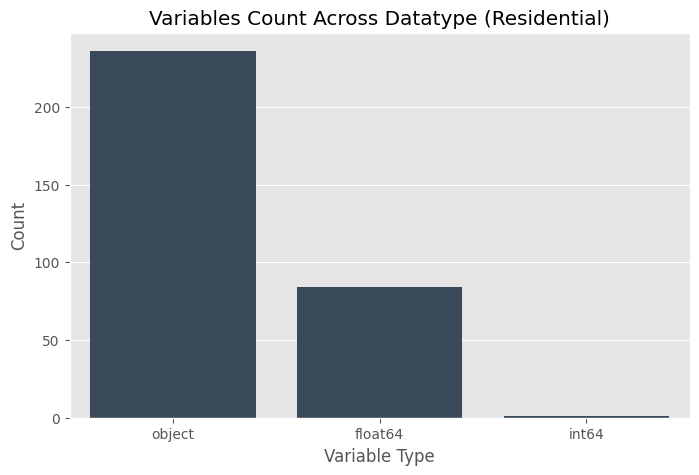

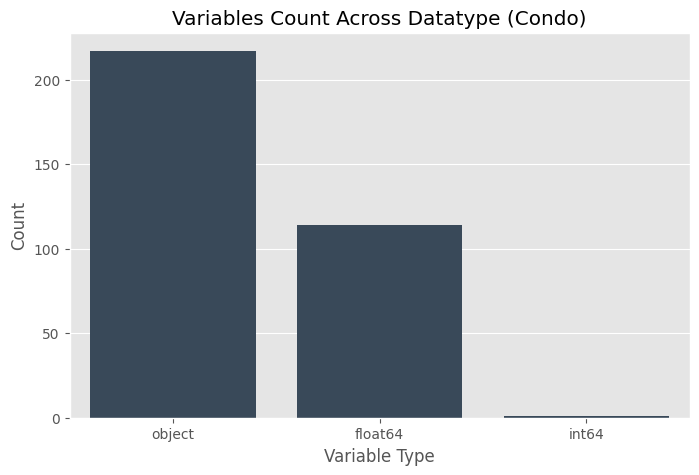

In [5]:
display_data_type_count(data_res, "Residential")
display_data_type_count(data_con, "Condo")

## Missing Values

In [6]:
def display_missing_values(data, ptype):
    
    missing_value_columns = data.columns[data.isnull().any()].tolist()
    null_vals = data.isnull().sum(axis = 0).sort_values(ascending=True)
    null_sorted_index = null_vals.index.tolist()
    missing_value_columns = sorted(missing_value_columns, key=lambda x:null_sorted_index.index(x))
    display_interval = 40
    try: 
        for i in range(0, len(missing_value_columns), display_interval):
            fig = msno.bar(data[missing_value_columns[i:i+display_interval]], figsize=(16,8),color="#34495e",fontsize=12,labels=True)#,sort="descending",)
            # fig.get_figure().savefig(f"prepare_data_db/missing_data/{folder_name}/{i:02d}.png")
            # fig.get_figure().clear()
            fig.get_figure().suptitle(f"{ptype} - {i}-{min(i+display_interval, len(missing_value_columns))}/{len(missing_value_columns)}")
            plt.show()
    except ValueError: 
        pass
    

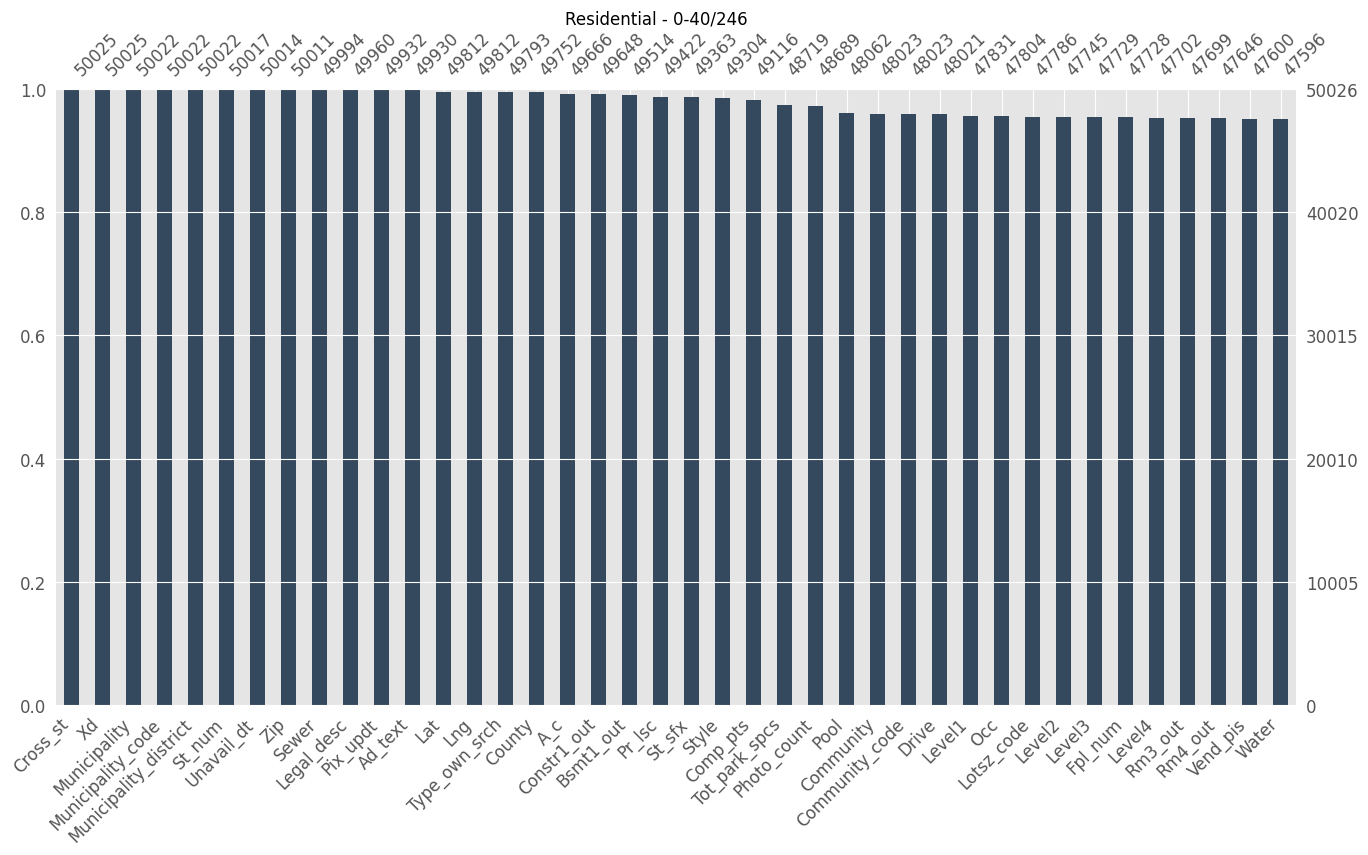

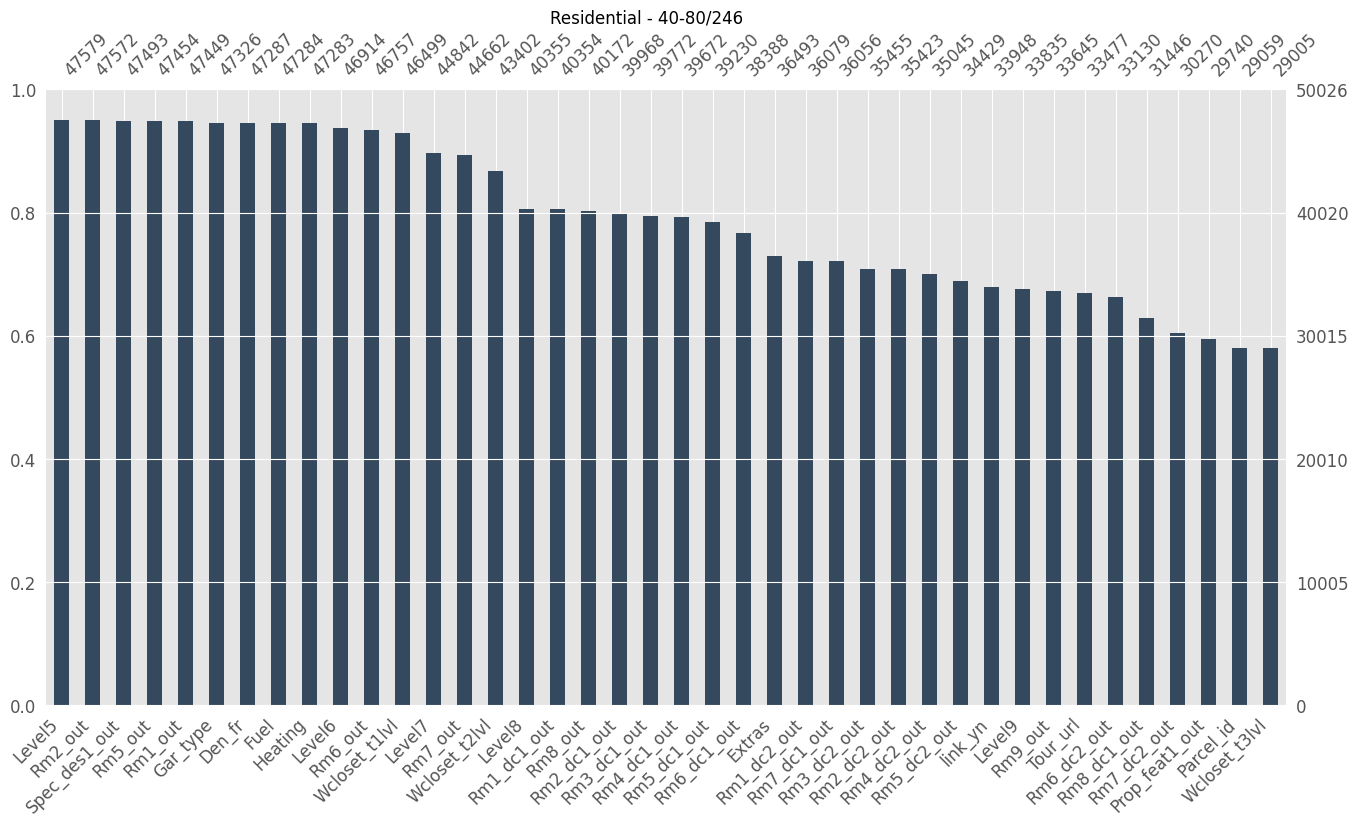

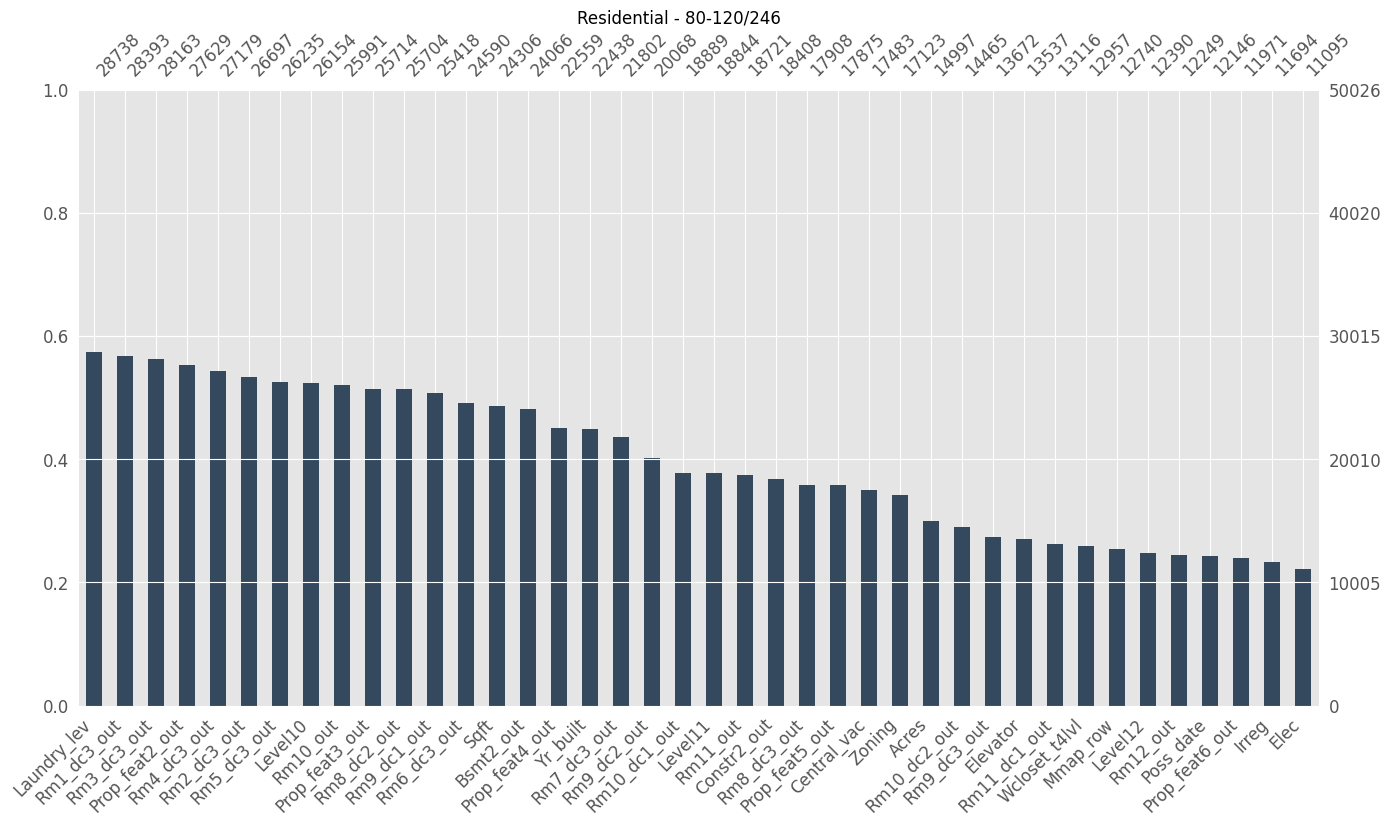

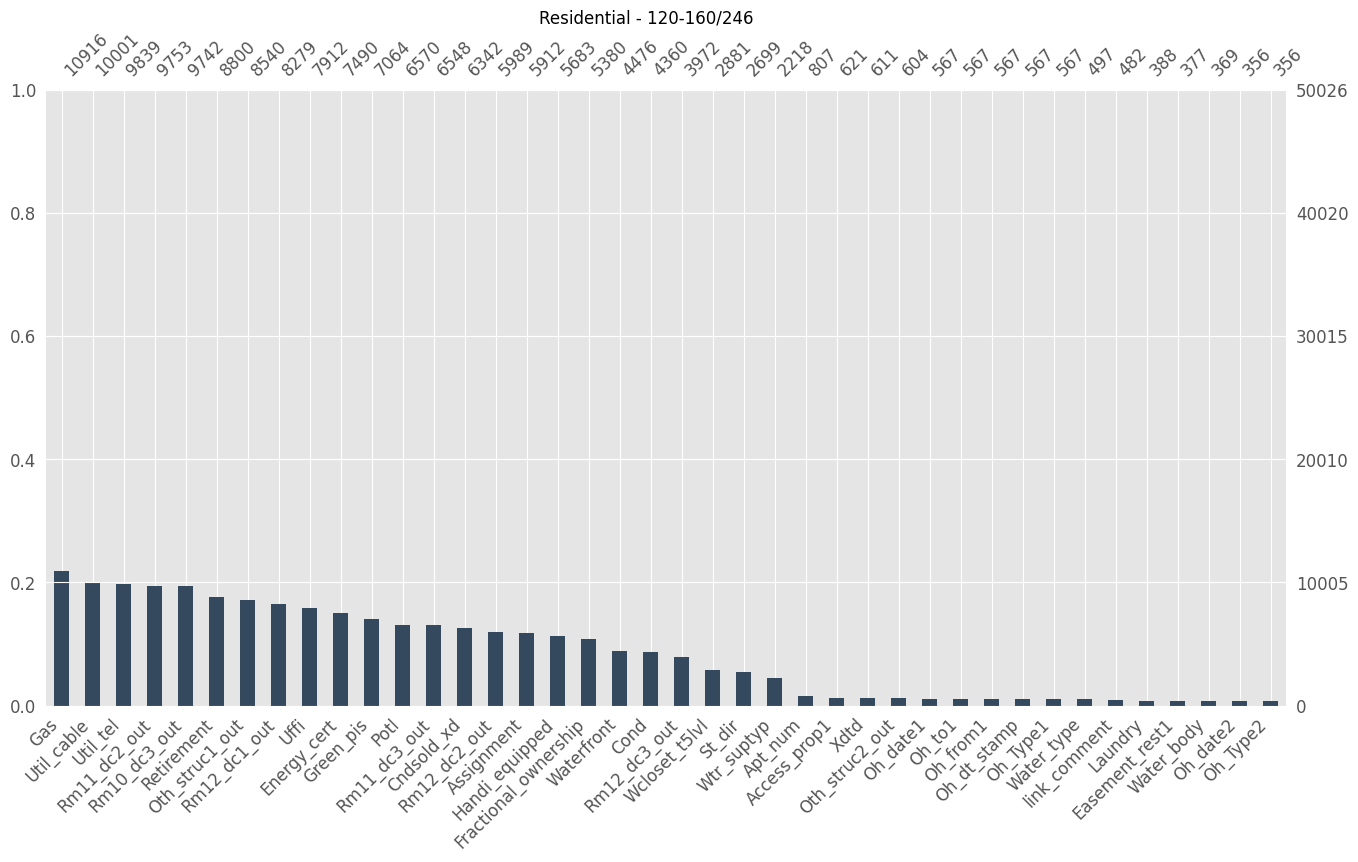

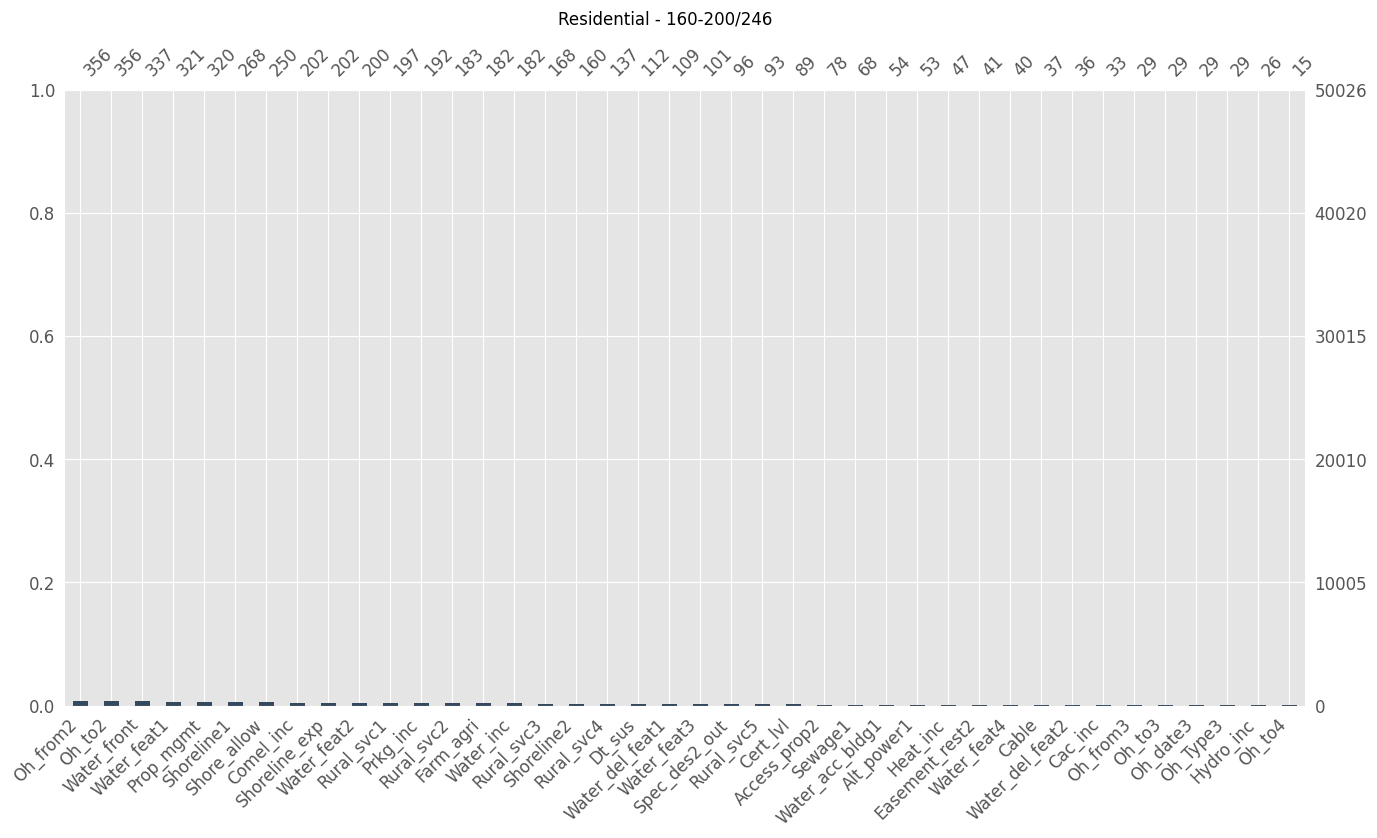

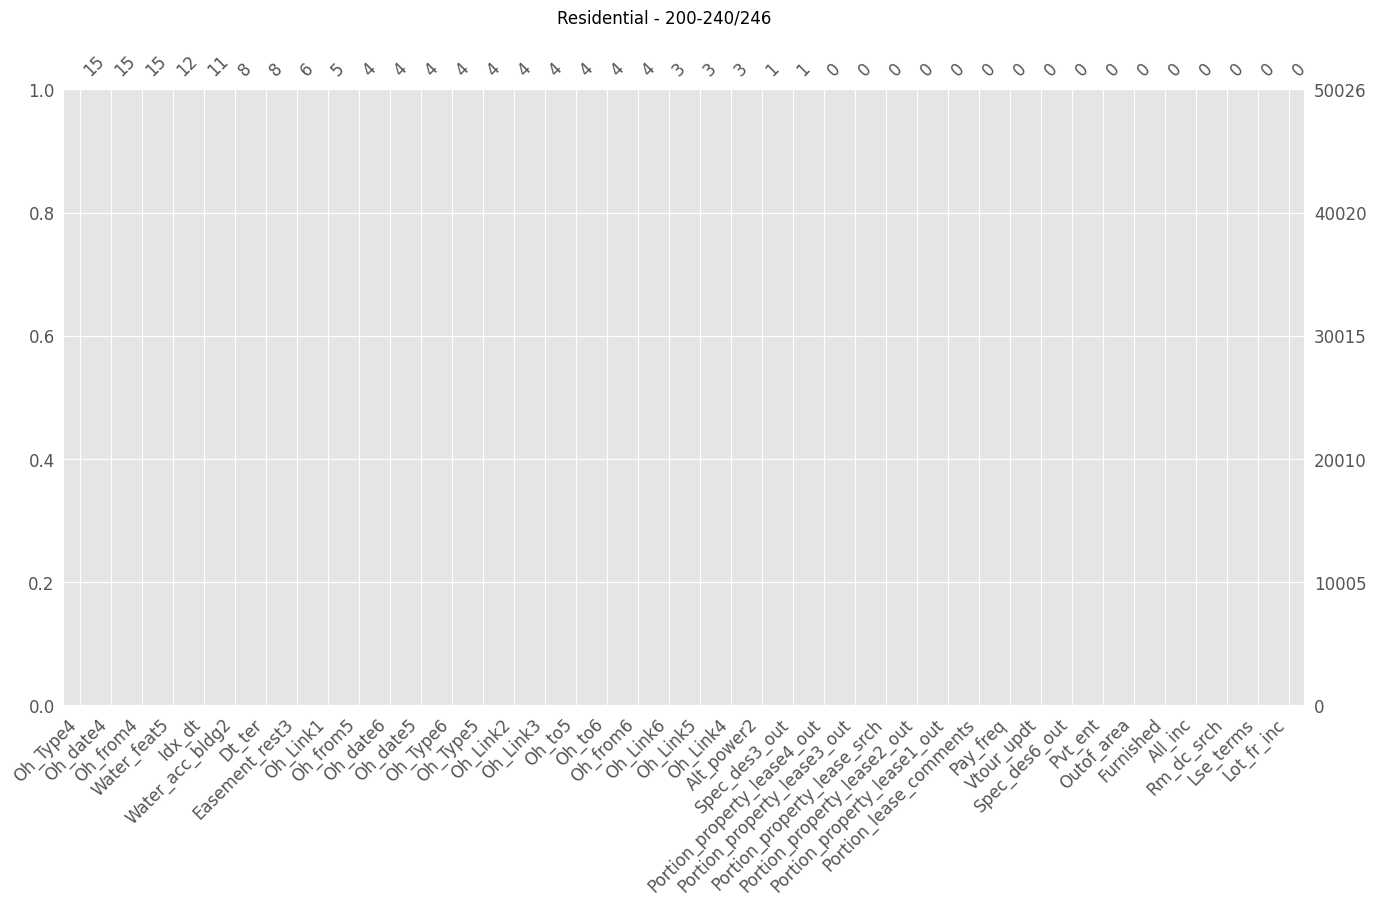

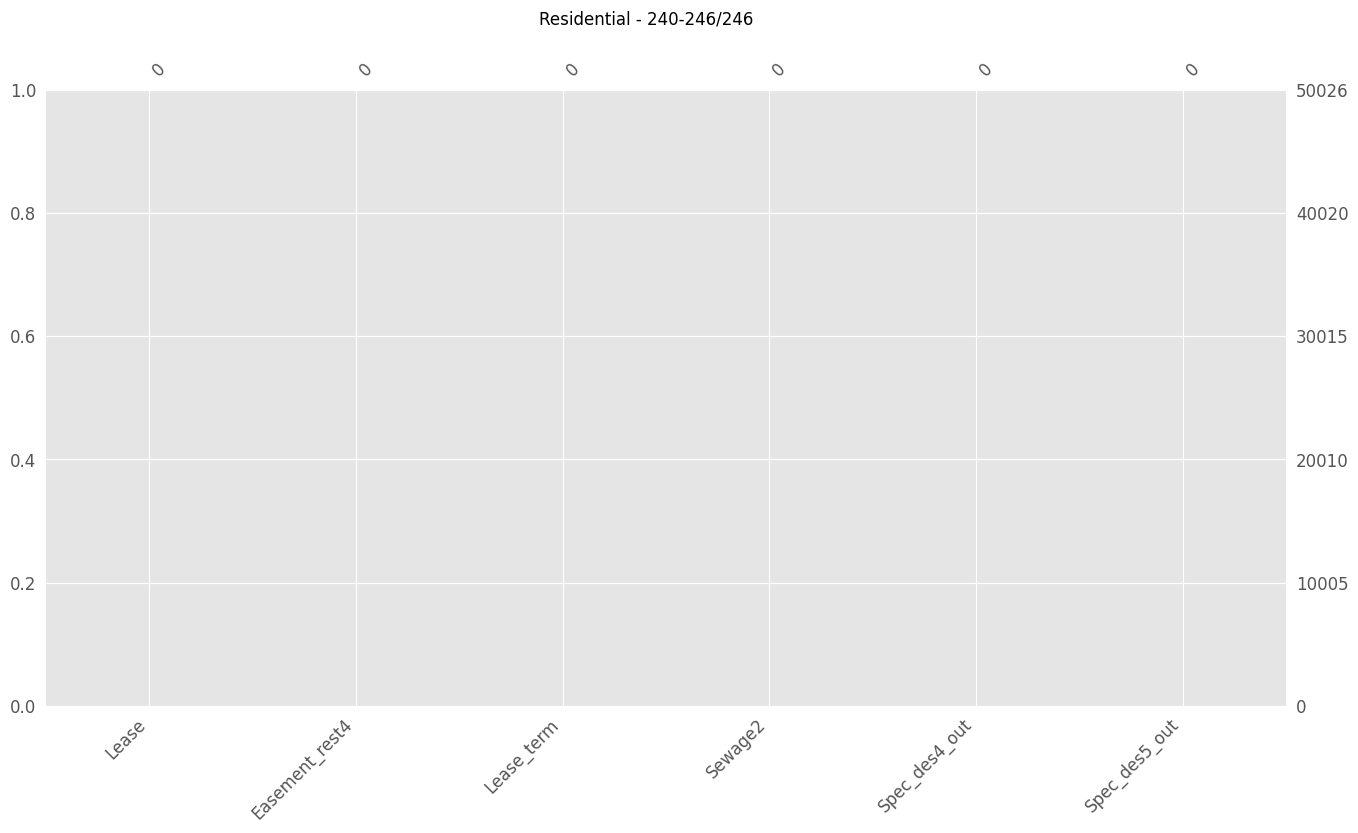

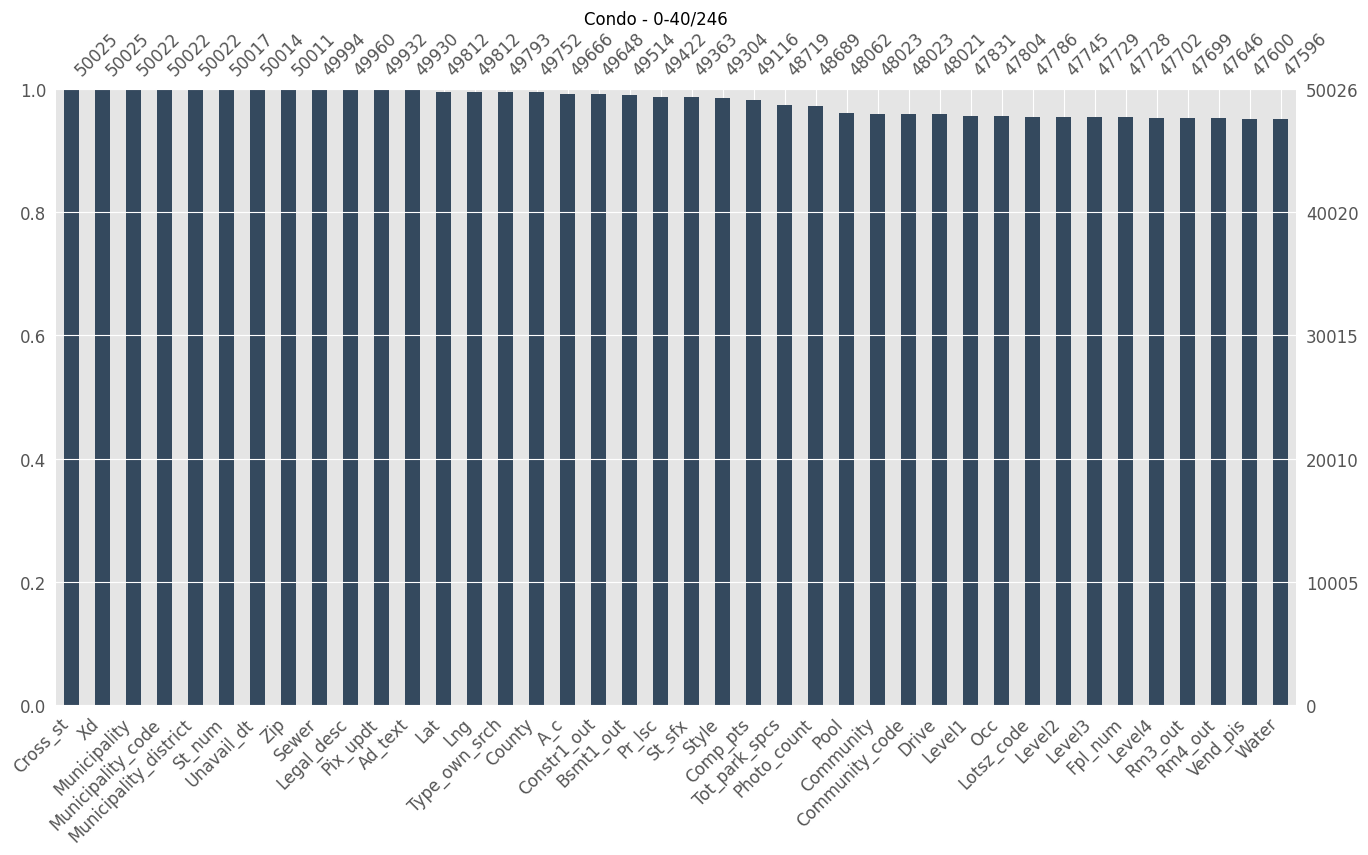

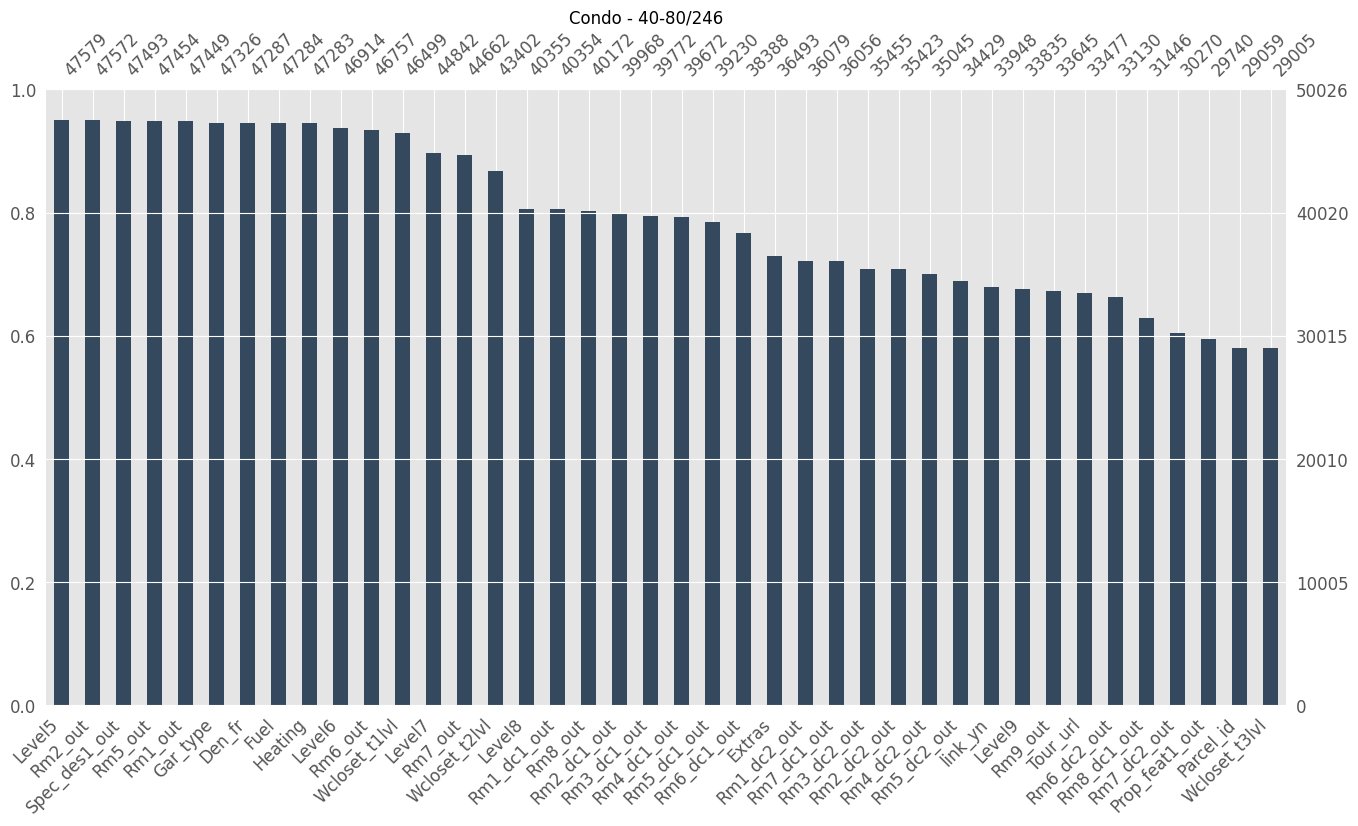

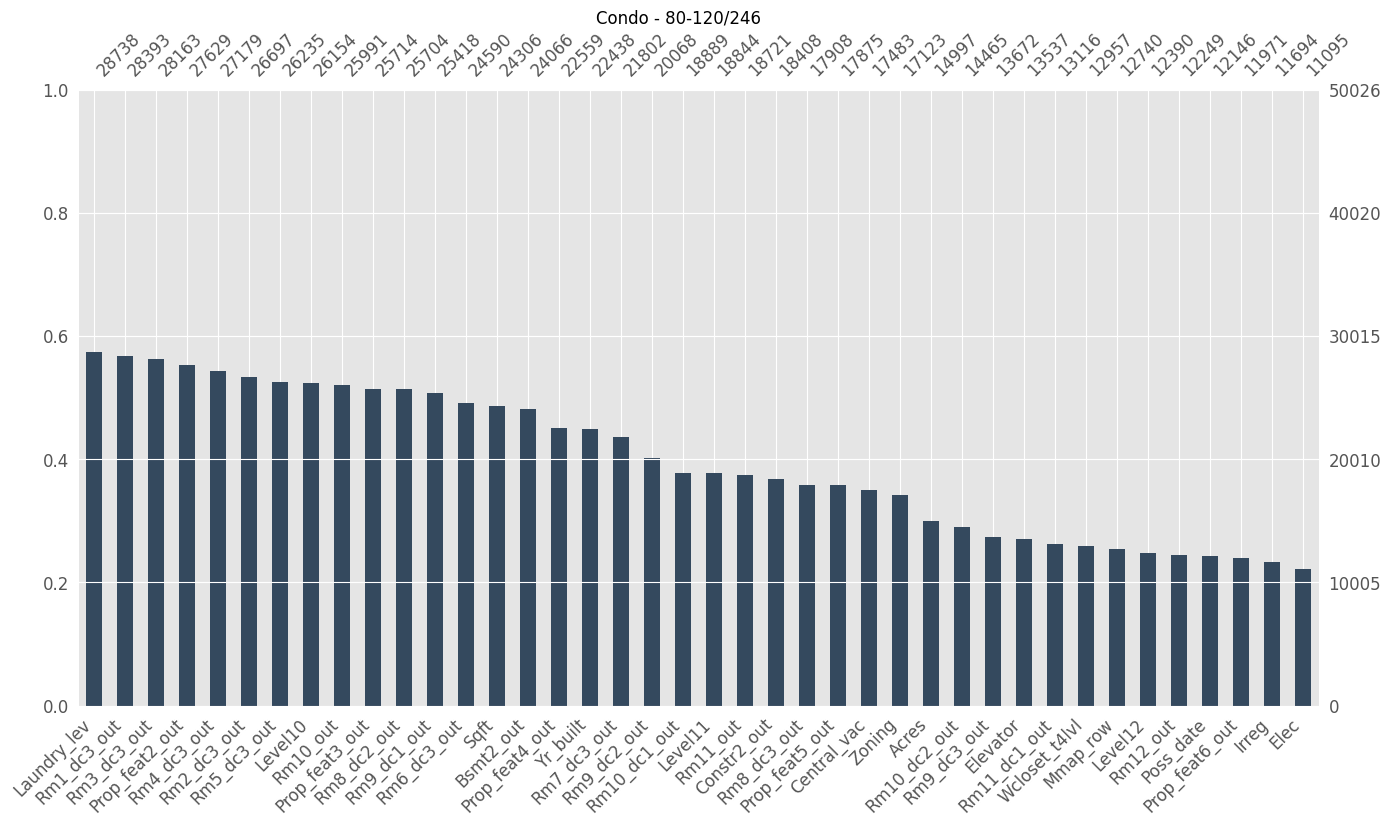

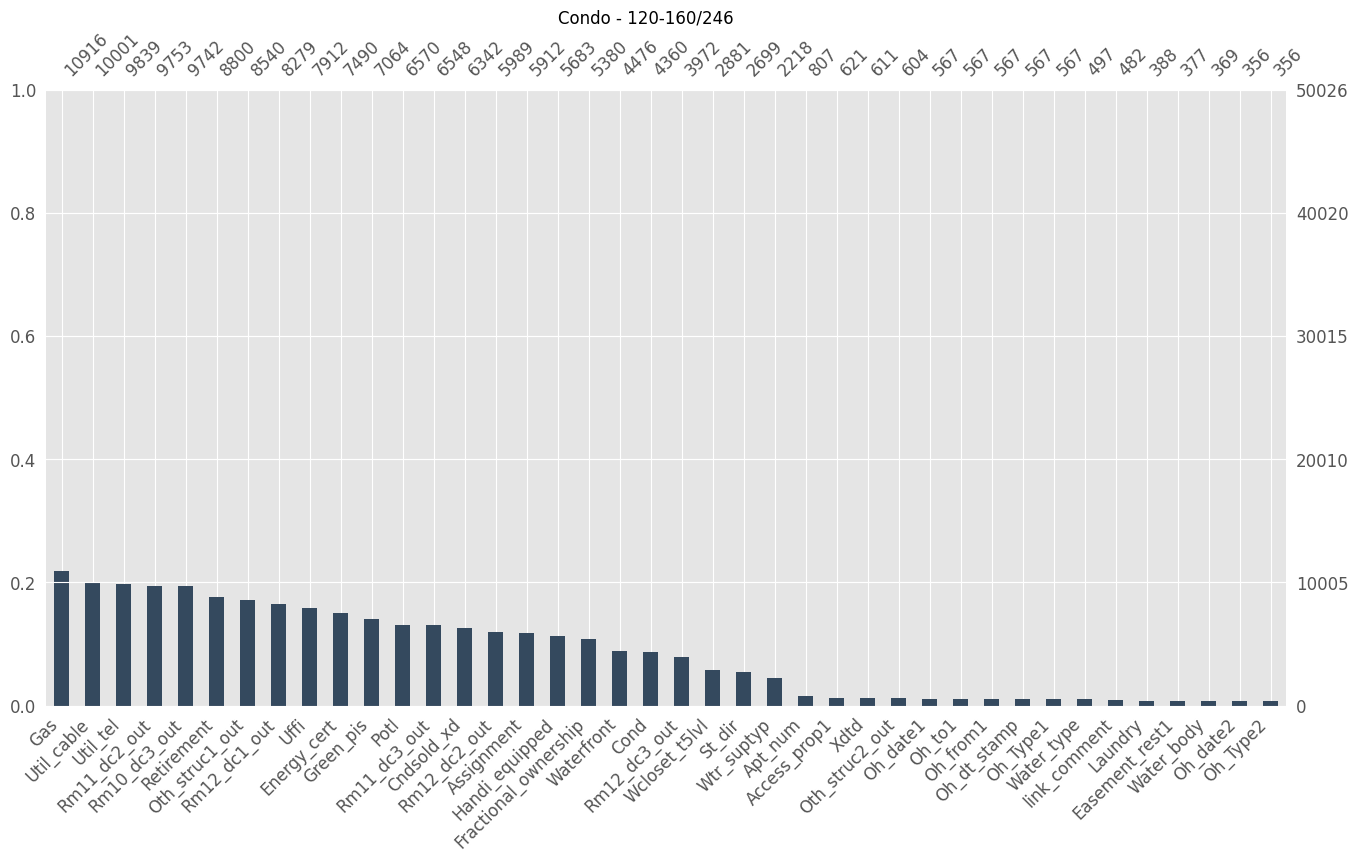

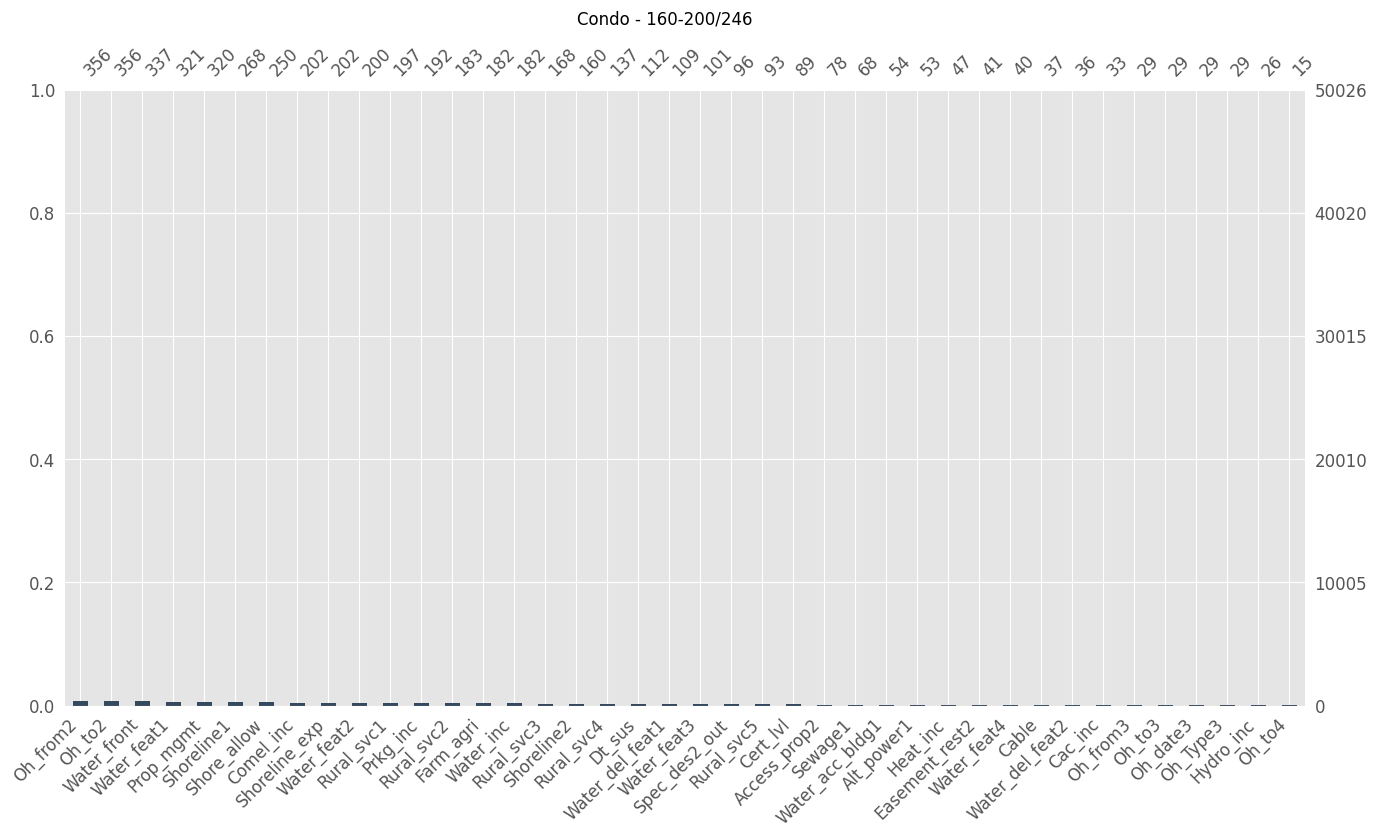

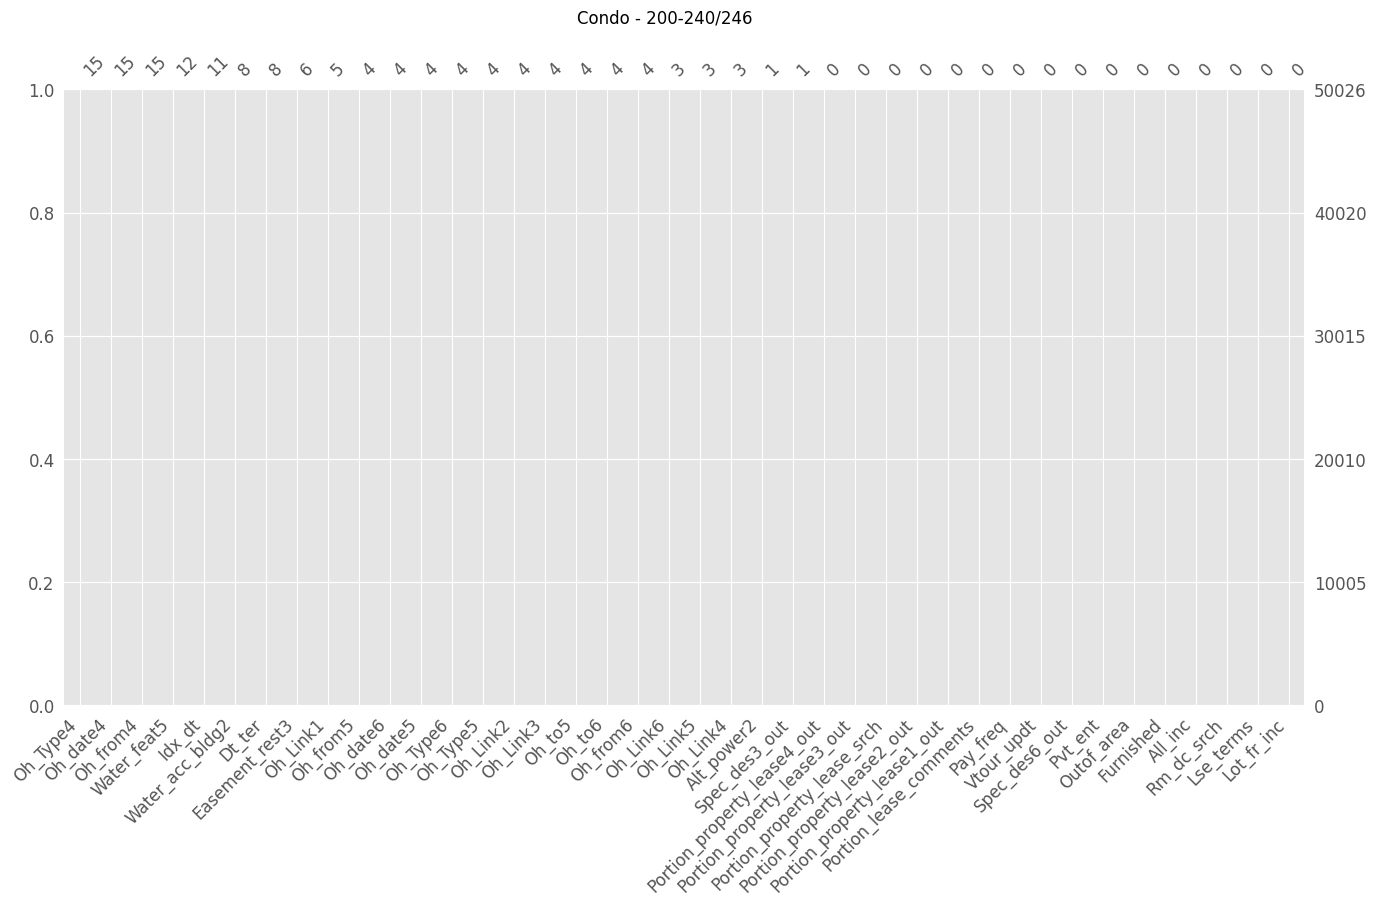

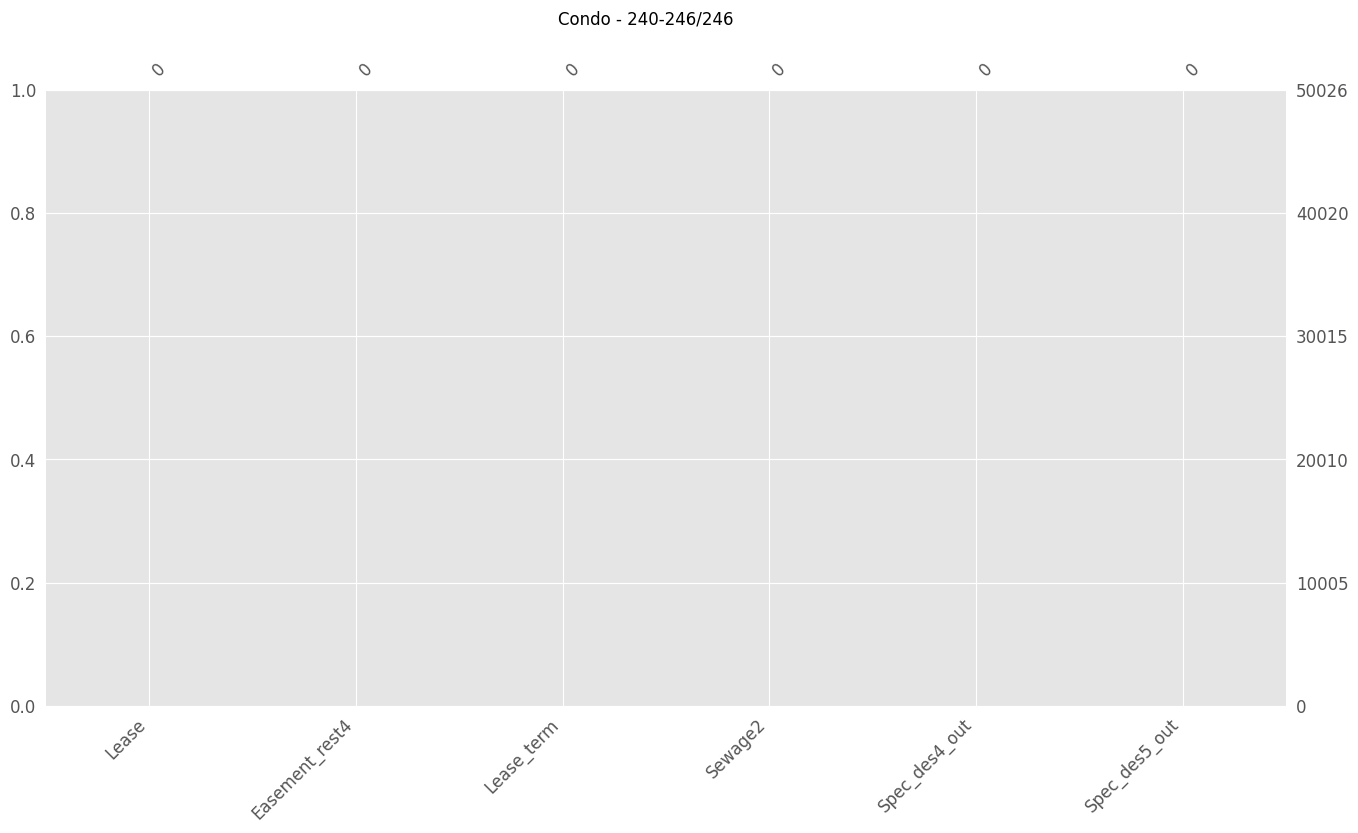

In [7]:
display_missing_values(data_res, "Residential")
display_missing_values(data_res, "Condo")

## Sold Price Distribution

In [8]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.describe.html
print("Residential")
print(data_res["Sp_dol"].describe().apply(lambda x: format(x, '0,.0f')))
print("="*50)
print("Condo")
print(data_con["Sp_dol"].describe().apply(lambda x: format(x, '0,.0f')))

Residential
count        50,026
mean      1,284,371
std         734,626
min          20,000
25%         885,000
50%       1,130,000
75%       1,462,950
max      25,000,000
Name: Sp_dol, dtype: object
Condo
count       26,171
mean       734,551
std        325,380
min          3,800
25%        575,000
50%        665,028
75%        807,000
max      7,600,000
Name: Sp_dol, dtype: object


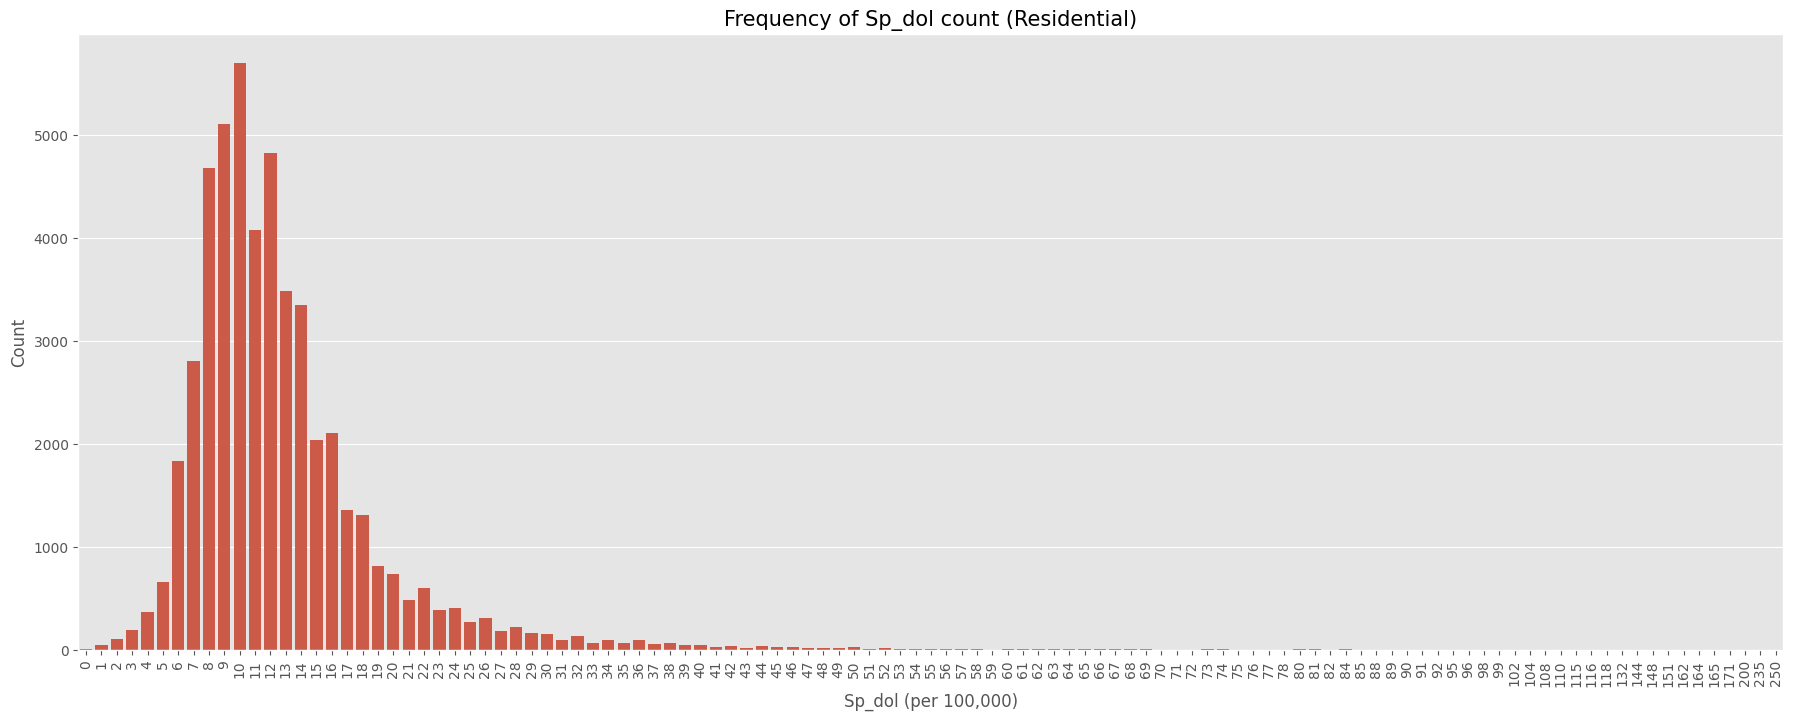

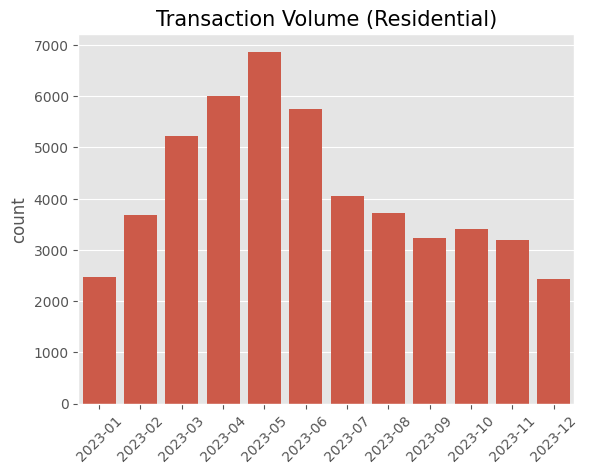

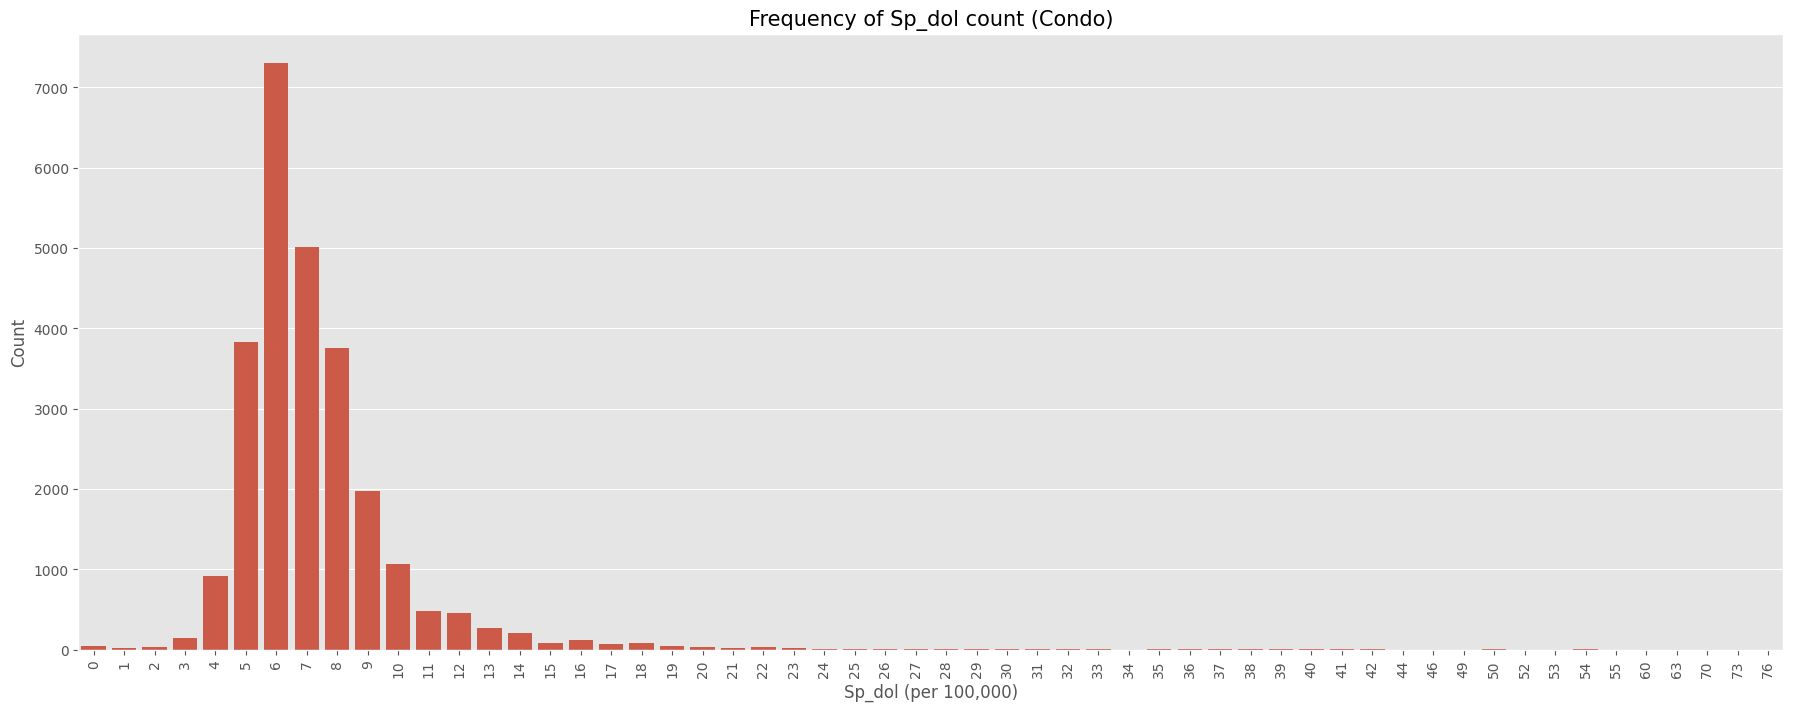

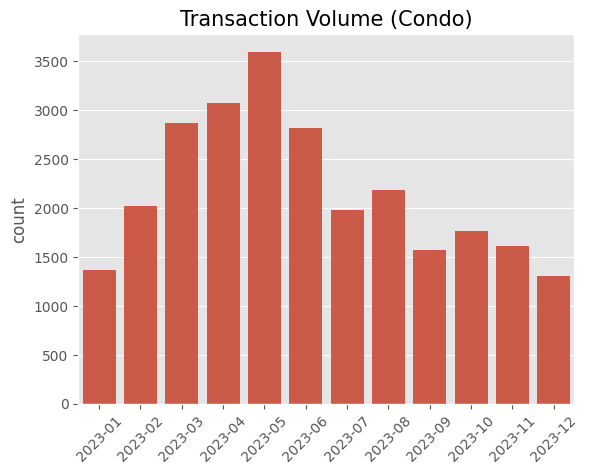

In [9]:



plt.figure(figsize=(22,8))
sn.countplot(x="Sp_dol", data=(data_res[["Sp_dol"]]/100000).round(0).astype(int))
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sp_dol (per 100,000)', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Sp_dol count (Residential)", fontsize=15)
plt.show()




data_res["Cd"] = pd.to_datetime(data_res["Cd"], errors='coerce',utc=False)
ax = sn.countplot(x=data_res.sort_values('Cd')['Cd'].dt.strftime('%Y-%m'))
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
# plt.tight_layout()
plt.title("Transaction Volume (Residential)", fontsize=15)
plt.show()










plt.figure(figsize=(22,8))
sn.countplot(x="Sp_dol", data=(data_con[["Sp_dol"]]/100000).round(0).astype(int))
plt.ylabel('Count', fontsize=12)
plt.xlabel('Sp_dol (per 100,000)', fontsize=12)
plt.xticks(rotation='vertical')
plt.title("Frequency of Sp_dol count (Condo)", fontsize=15)
plt.show()




data_con["Cd"] = pd.to_datetime(data_con["Cd"], errors='coerce',utc=False)
ax = sn.countplot(x=data_con.sort_values('Cd')['Cd'].dt.strftime('%Y-%m'))
ax.tick_params(axis='x', rotation=45)
ax.set_xlabel('')
# plt.tight_layout()
plt.title("Transaction Volume (Condo)", fontsize=15)
plt.show()

## Drop Missing Value Columns

Decide how much missing data to consider not used
- https://pandas.pydata.org/docs/user_guide/missing_data.html
- [How to handle Missing values?](https://medium.com/analytics-vidhya/how-to-handle-missing-values-cbd03fb79ef8#:~:text=Records%20which%20has%20null%20values,which%20has%20more%20missing%20value.&text=Column%20Score4%20has%20more%20null,%25%20missing%20value%2C%20drop%20it.)
  1. If missing values in target column, drop the record by dropna.
  2. If more than 70 % missing values in a column, drop the record by drop.
  3. Fill the missing by using fillna.
  4. fillna : take mean for integer column.
  5. fillna : take mode for categorical column.
- [What should be the allowed percentage of Missing Values?](https://web.archive.org/web/20231001190347/https://discuss.analyticsvidhya.com/t/what-should-be-the-allowed-percentage-of-missing-values/2456)
  - Theoretically, 25 to 30% is the maximum missing values are allowed, beyond which we might want to drop the variable from analysis. Practically this `varies.At` times we get variables with ~50% of missing values but still the customer insist to have it for analyzing. In those cases we might want to treat them accordingly.
  - As @karthe1 suggested, this varied from case to case and the amount of information you think the variable has. For example, if you are working on some dataset which contains a column for date of marriage. It may be blank for 50% (or even more) of the population, but might have very high information about the lifestyle of the person. In such cases, you would still use the variable.
  - If the information contained in the variable is not that high, you can drop the variable if it has more than 50% missing values. I have seen projects / models where imputation of even 20 - 30% missing values provided better results - the famous Titanic dataset on Kaggle being one such case. Age is missing in ~20% of cases, but you benefit by imputing them rather than ignoring the variable.


In [10]:
print(f"Residential data shape: {data_res.shape}")
print(f"      Condo data shape: {data_con.shape}")

# https://stackoverflow.com/questions/49791246/drop-columns-with-more-than-60-percent-of-empty-values-in-pandas

def display_field_value_count(data, field, ptype):
    print(f"{ptype} - {field} - {np.sum(data[field].count())}/{len(data)}")

def display_missing_columns(data, null_percentage_threshold, ptype):
    
    # replace some strings to NaN (Keep 'None', some fields have it. For example, 'Pool' has 'None')
    null_percentage = data.replace(['',' ','NULL', 'null'], np.nan).isnull().sum()/data.shape[0]*100
    
    # find columns that have missing values more than given percentage
    col_to_drop = null_percentage[null_percentage>null_percentage_threshold].keys()
    print(f"{ptype}:")
    print(list(col_to_drop))
    print("Columns to drop count:", len(col_to_drop))
    # data = data.drop(col_to_drop, axis=1)

threshold = 80
display_missing_columns(data_res, threshold, "Residential")

# Acres is important

print("="*50)

display_missing_columns(data_con, threshold, "Condo")

# some fields are for lease listings (e.g. All_inc, Laundry, Furnished...)

print("="*50)

display_field_value_count(data_res, "Acres", "Residential")
display_field_value_count(data_res, "Water_acc_bldg1", "Residential")
display_field_value_count(data_res, "Water_acc_bldg2", "Residential")
display_field_value_count(data_res, "Pool", "Residential")

# print(data_res["Pool"])
# print(data_res["Acres"])

Residential data shape: (50026, 321)
      Condo data shape: (26171, 332)
Residential:
['Heat_inc', 'Spec_des6_out', 'Water_body', 'Water_type', 'Water_front', 'Access_prop1', 'Easement_rest1', 'Easement_rest2', 'Easement_rest3', 'Easement_rest4', 'Rural_svc1', 'Rural_svc2', 'Rural_svc3', 'Rural_svc4', 'Rural_svc5', 'Water_acc_bldg1', 'Water_acc_bldg2', 'Water_del_feat1', 'Water_del_feat2', 'Sewage1', 'Sewage2', 'Potl', 'Access_prop2', 'Water_feat1', 'Water_feat2', 'Water_feat3', 'Water_feat4', 'Water_feat5', 'Shoreline1', 'Shoreline2', 'Shore_allow', 'Shoreline_exp', 'Alt_power1', 'Alt_power2', 'Hydro_inc', 'Laundry', 'Lse_terms', 'All_inc', 'Apt_num', 'Cable', 'Cac_inc', 'Comel_inc', 'Farm_agri', 'Furnished', 'Oth_struc1_out', 'Oth_struc2_out', 'Outof_area', 'Prkg_inc', 'Pvt_ent', 'Retirement', 'Rm10_dc3_out', 'Rm11_dc2_out', 'Rm11_dc3_out', 'Rm12_dc1_out', 'Rm12_dc2_out', 'Rm12_dc3_out', 'Spec_des2_out', 'Spec_des3_out', 'Spec_des4_out', 'Spec_des5_out', 'St_dir', 'Uffi', 'Util_cabl

## Manual Selection (Residential)

In [11]:
# print one example to see the metadata structure
print(metadata_res["Comp_pts"])


def display_metadata(data, metadata):

    # When export data, below fields are removed accidentially or not the TREB system not include these new fields in metadata
    not_exists_fields = ["Perc_dif", "Link_yn", "Link_Comment"]
    skip_fields = ["Ml_num"]

    # null_percentage = data.replace(['',' ','NULL', 'null'], np.nan).isnull().sum()
    r = {}
    for k,v in metadata.items():
        if k in not_exists_fields or k in skip_fields:
            continue
        lookup_values = ""
        if v["LookupValues"]:
            lookup_values = list(map(lambda x:x["Value"], v["LookupValues"]))

        # for lookup values list, only show first 5 values, due to some lists are super long
        # .count(): Count non-NA cells for each column or row. The values None, NaN, NaT, pandas.NA are considered NA.
        # print(f"{k} - {v['LongName']} - not NA: {np.sum(data[k].count())}/{len(data)} - {np.sum(data[k].count())/len(data):.2f} - {lookup_values[:5]}")
        r[k] = f"{v['LongName']} - not NA: {np.sum(data[k].count())}/{len(data)} - {np.sum(data[k].count())/len(data):.2%} - {lookup_values[:5]}"
    # print(json.dumps(r, indent=2, ensure_ascii=False))
    return r

{'SystemName': 'Comp_pts', 'LongName': 'Fronting On (NSEW)', 'MaximumLength': '1', 'DataType': 'Character', 'Precision': '0', 'LookupValues': [{'Value': 'E', 'LongValue': 'E'}, {'Value': 'N', 'LongValue': 'N'}, {'Value': 'S', 'LongValue': 'S'}, {'Value': 'W', 'LongValue': 'W'}]}


### First print out the information in json, copy it to code, review it and remove useless ones manually.

In [12]:
metadata_info_res = display_metadata(data_res, metadata_res)
print(json.dumps(metadata_info_res, indent=2, ensure_ascii=False))

{
  "Comp_pts": "Fronting On (NSEW) - not NA: 49116/50026 - 98.18% - ['E', 'N', 'S', 'W']",
  "Cond": "Condition - not NA: 4360/50026 - 8.72% - ",
  "Constr1_out": "Exterior1 - not NA: 49648/50026 - 99.24% - ['Alum Siding', 'Board/Batten', 'Brick', 'Brick Front', 'Concrete']",
  "Constr2_out": "Exterior2 - not NA: 18408/50026 - 36.80% - ['Alum Siding', 'Board/Batten', 'Brick', 'Brick Front', 'Concrete']",
  "County": "Province - not NA: 49752/50026 - 99.45% - ",
  "Cross_st": "Directions/Cross Streets - not NA: 50025/50026 - 100.00% - ",
  "Den_fr": "Family Room - not NA: 47287/50026 - 94.52% - ['N', 'Y']",
  "Depth": "Lot Depth - not NA: 50026/50026 - 100.00% - ",
  "Disp_addr": "Display Address On Internet - not NA: 50026/50026 - 100.00% - ",
  "Dom": "Days On Market - not NA: 50026/50026 - 100.00% - ",
  "Drive": "Drive - not NA: 48021/50026 - 95.99% - ['Available', 'Circular', 'Front Yard', 'Lane', 'Mutual']",
  "Dt_sus": "Suspended Date - not NA: 112/50026 - 0.22% - ",
  "Dt_ter":

In [13]:
def display_column_info(data, field, display_limit=None):
    print("        dtypes:", data[field].dtypes)
    # data[field].replace([False], np.nan).notnull().head(3)
    print(" uniques count:", data[field].nunique())
    print("not null count:", data[field].count())
    print("   total count:", data.shape[1])
    print("="*50)
    print("count for each unique value:")
    print(data[field].value_counts().head(display_limit))


# useless
# display_column_info(data_res, "Cond", display_limit=5) # sold condiction
# display_column_info(data_res, "County", display_limit=None) # only one value: Ontario
# display_column_info(data_res, "Dt_sus", display_limit=None) # suspend date
# display_column_info(data_res, "Farm_agri", display_limit=None)


# might NOT useful:
# display_column_info(data_res, "Fuel", display_limit=None)

# might be useful:
# display_column_info(data_res, "Cross_st", display_limit=5) # user input cross street text


# require data manipulation
# display_column_info(data_res, "Disp_addr", display_limit=5)
# display_column_info(data_res, "Elevator", display_limit=None)
# display_column_info(data_res, "Gar_spaces", display_limit=None)

# may need to specify house type for prediction (e.g., exclude farms?)

# filter out:
# display_column_info(data_res, "Internet", display_limit=None)
# display_column_info(data_res, "Type_own1_out", display_limit=None)
# display_column_info(data_res, "Style", display_limit=None)


# text
# display_column_info(data_res, "Extras", display_limit=5)
# display_column_info(data_res, "Ad_text", display_limit=5)



display_column_info(data_res, "Style", display_limit=None)

        dtypes: object
 uniques count: 17
not null count: 49304
   total count: 321
count for each unique value:
2-Storey           30044
Bungalow            8243
3-Storey            2954
Bungalow-Raised     2530
1 1/2 Storey        1166
Backsplit 4          829
2 1/2 Storey         754
Sidesplit 4          657
Backsplit 3          643
Sidesplit 3          516
Bungaloft            379
Backsplit 5          341
Other                140
Sidesplit 5          104
Stacked Townhse        2
Loft                   1
3 Storey               1
Name: Style, dtype: int64


## Data Manipulation (Residential)

### Some fields might be useful, but may requires a special way to handle it.
For example, there are 12 rooms fields, each has a type, length and width. We may need to convert the column room_number to room_type. Then another fields to represent it's count, size etc. But since the fields seem not very useful, we will ignore it for now. Alo there are already have fields to represent total bedrooms, washroom etc.

In [14]:
# ignore: 
# - Rm1 - Rm12 replated fields. (Level1 - Level12 are for Rm1 - Rm12) (room types and size)
# - Wcloset_p1, t1 to p5, t5. (washroom types)
# - Mmap_ related (duplicate with geolocation information)
# - Rltr: listing brokerage name
# - address related:
#     - St, St_dir, St_num, St_sfx, Apt_num, Addr

# ignore text:
# - Cross_st
# - Extras
# - Ad_text


# ignore for now:
# - Prop_feat1_out - Prop_feat6_out (School, Hospital etc.)
#    - we could convert Prop_feat1_out - Prop_feat6_out to categorical and counts
#    - but these fields are input by agents, they may not accurate, we may use Google API to find actual POI (point of interest).



# filter out:
# - Internet: Y or N <- ignore this one, even it's N, we still have all information in database
# - Disp_addr: same as above


# some fields should not included (data leakage):
# https://machinelearningmastery.com/data-leakage-machine-learning/
# when the data you are using to train a machine learning algorithm happens to have the information you are trying to predict
# - Cd, Sp_dol, Dom, 

# some important fields to ignore:
# - Lp_dol, Orig_dol: this is like human approx. price, ignore it


# TODO: for categorial data, what if the value not exist during test time?




# lot size
def handle_lot_size(x):
    
    if x["Front_ft"] == 0:
        val = x["Depth"]
    elif x["Depth"] == 0:
        val = x["Front_ft"]
    else:
        val = x["Front_ft"] * x["Depth"]
    
    if not val:
        return val
    
    # convert all units to Feet
    if x["Lotsz_code"] == "Feet":
        return val
    elif x["Lotsz_code"] == "Metres":
        return val * 3.28084
    elif x["Lotsz_code"] == "Acres":
        return val * 43560
    else:
        return val
    

# Assessment, Tax
# "Tv": "Assessment - not NA: 50026/50026 - 100.00% - ",
# "Taxes": "Taxes - not NA: 50026/50026 - 100.00% - ",
# "Yr": "Tax Year - not NA: 50026/50026 - 100.00% - ",
# "Ass_year": "Assessment Year - not NA: 50026/50026 - 100.00% - ",

# convert 0 to None, and keep number only, drop those years (assuming the year is the latest year it can get when listing)
# def handle_tax_assessment(x):
    
#     if x["Taxes"] == 0:
#         x["Taxes"] = np.nan()
#     if x["Tv"] == 0:
#         x["Tv"] = np.nan()



# Tour_url: convert it to boolean
# "Tour_url": "Virtual Tour URL - not NA: 33477/50026 - 66.92% - ",
# def handle_tour_url(x):
#     return True if x["Tour_url"].strip() else False
    
    

# handle parking related fields:
#   "Tot_park_spcs": "Total Parking Spaces - not NA: 48719/50026 - 97.39% - ",
#   "Gar_spaces": "Garage Spaces - not NA: 50026/50026 - 100.00% - ",
#   "Gar_type": "Garage Type - not NA: 47326/50026 - 94.60% - ['Attached', 'Built-in', 'Carport', 'Detached', 'None']",
#   "Park_spcs": "Parking Spaces - not NA: 50026/50026 - 100.00% - ",
# by checking manually, seems Tot_park_spcs is just the sum of Gar_spaces + Park_spcs
# col_to_remove.append("Tot_park_spcs")


# fields to drop, but might be useful (these fields are those not much missing values)
#   "Sewer": "Sewers - not NA: 49994/50026 - 99.94% - ['None', 'Other', 'Septic', 'Sewers', 'Tank']",
#   "Retirement": "Retirement - not NA: 8800/50026 - 17.59% - ['N', 'Y']",
#   "Laundry_lev": "Laundry Level - not NA: 28738/50026 - 57.45% - ['Lower', 'Main', 'Upper']",
#   "Central_vac": "Central Vac - not NA: 17483/50026 - 34.95% - ['N', 'Y']",
#   "Fractional_ownership": "FractionalOwnership - not NA: 5380/50026 - 10.75% - ['N', 'Y']",
#   "Assignment": "Assignment - not NA: 5912/50026 - 11.82% - ['N', 'Y']",
#   "Energy_cert": "Energy Certification - not NA: 7490/50026 - 14.97% - ['N', 'Y']",
#   "Handi_equipped": "Physically Handicapped-Equipped - not NA: 5683/50026 - 11.36% - ['N', 'Y']",
#   "Zoning": "Zoning - not NA: 17123/50026 - 34.23% - ",
#   "Water": "Water - not NA: 47596/50026 - 95.14% - ['Both', 'Municipal', 'None', 'Other', 'Well']",
#   "Uffi": "UFFI - not NA: 7912/50026 - 15.82% - ['No', 'Part Removed', 'Removed', 'Yes']",
#   "Util_cable": "Utilities-Cable - not NA: 10001/50026 - 19.99% - ['A', 'N', 'Y']",
#   "Util_tel": "Utilities-Telephone - not NA: 9839/50026 - 19.67% - ['A', 'N', 'Y']",
#   "Vend_pis": "Seller Property Info Statement - not NA: 47600/50026 - 95.15% - ['Insp Avail', 'N', 'None', 'SPIS Avail', 'SPIS/Insp']",
#   "Gas": "Utilities-Gas - not NA: 10916/50026 - 21.82% - ['A', 'N', 'Y']",

might_keep = ["Sewer", "Retirement", "Laundry_lev", "Central_vac", "Fractional_ownership", "Assignment", "Energy_cert", "Handi_equipped", "Zoning", "Water", "Uffi", "Util_cable", "Util_tel", "Vend_pis", "Gas"]




#   "Drive": "Drive - not NA: 48021/50026 - 95.99% - ['Available', 'Circular', 'Front Yard', 'Lane', 'Mutual']",
#   "Elevator": "Elevator - not NA: 13537/50026 - 27.06% - ['N', 'Y']",
#   "Fuel": "Heat Source - not NA: 47284/50026 - 94.52% - ['Electric', 'Gas', 'Grnd Srce', 'Oil', 'Other']",
#   "Heating": "Heat Type - not NA: 47283/50026 - 94.52% - ['Baseboard', 'Forced Air', 'Heat Pump', 'Other', 'Radiant']",
#   "Pool": "Pool - not NA: 48062/50026 - 96.07% - ['Abv Grnd', 'Indoor', 'Inground', 'None']",
#   "Waterfront": "Waterfront - not NA: 4476/50026 - 8.95% - ['Direct', 'Indirect', 'None']",
#   "A_c": "Air Conditioning - not NA: 49666/50026 - 99.28% - ['Central Air', 'None', 'Other', 'Wall Unit', 'Window Unit']",

may_keep = ["Drive", "Elevator", "Fuel", "Heating", "Pool", "Waterfront", "A_c"]





#   "Bath_tot": "Washrooms - not NA: 50026/50026 - 100.00% - ",
#   "Br": "Bedrooms - not NA: 50026/50026 - 100.00% - ",
#   "Br_plus": "Bedrooms + - not NA: 50026/50026 - 100.00% - ",
#   "Rms": "Rooms - not NA: 50026/50026 - 100.00% - ",
#   "Rooms_plus": "Rooms + - not NA: 50026/50026 - 100.00% - ",
#   "Kit_plus": "Kitchens Plus - not NA: 50026/50026 - 100.00% - ",
#   "Num_kit": "Kitchens - not NA: 50026/50026 - 100.00% - ",

# for the plus, it shows in MLS website like 1+1. For example, if it has a Den, it shows bedroom as 1+1.
# Rms: sometimes for condo it has so many rooms.. it's not actually rooms, by just areas

keep_num_fields = [
    "Bath_tot", "Br", "Br_plus", "Rms", "Rooms_plus", "Kit_plus", "Num_kit",
    "Gar_spaces", "Park_spcs",
    # "Tv", "Taxes",
]


#   "Comp_pts": "Fronting On (NSEW) - not NA: 49116/50026 - 98.18% - ['E', 'N', 'S', 'W']",
#   "Constr1_out": "Exterior1 - not NA: 49648/50026 - 99.24% - ['Alum Siding', 'Board/Batten', 'Brick', 'Brick Front', 'Concrete']",
#   "Constr2_out": "Exterior2 - not NA: 18408/50026 - 36.80% - ['Alum Siding', 'Board/Batten', 'Brick', 'Brick Front', 'Concrete']",
#   "Bsmt1_out": "Basement1 - not NA: 49514/50026 - 98.98% - ['Apartment', 'Crawl Space', 'Fin W/O', 'Finished', 'Full']",
#   "Bsmt2_out": "Basement2 - not NA: 24066/50026 - 48.11% - ['Apartment', 'Crawl Space', 'Fin W/O', 'Finished', 'Full']",
#   "Yr_built": "Approx Age - not NA: 22438/50026 - 44.85% - ['0-5', '100+', '16-30', '31-50', '51-99']",
#   "Acres": "Acreage - not NA: 14997/50026 - 29.98% - ['< .49', '.50-1.99', '100+', '10-24.99', '2-4.99']",
#   "Sqft": "Approx Square Footage - not NA: 24306/50026 - 48.59% - ['< 700', '1100-1500', '1500-2000', '2000-2500', '2500-3000']",
#   "Style": "Style - not NA: 49304/50026 - 98.56% - ['1 1/2 Storey', '2 1/2 Storey', '2-Storey', '3-Storey', 'Apartment']",
#   "Type_own1_out": "Type - not NA: 50026/50026 - 100.00% - ['6', 'A', 'B', 'D', 'F']",
#   "Zip": "Postal Code - not NA: 50011/50026 - 99.97% - ",
#   "Area": "Area - not NA: 50026/50026 - 100.00% - ",
#   "Community": "Community - not NA: 48023/50026 - 96.00% - ",
#   "Irreg": "Lot Irregularities - not NA: 11694/50026 - 23.38% - ",
#   "Spec_des1_out": "Special Designation1 - not NA: 47493/50026 - 94.94% - ['Accessibility', 'Crcd-Certif Granted', 'Expropriation', 'Heritage', 'Landlease']",
#   "Municipality_district": "Municipality District - not NA: 50022/50026 - 99.99% - ",

keep_cat_fields = [
    "Comp_pts",
    "Gar_type",
]



# convert fields to boolean
#   "Den_fr": "Family Room - not NA: 47287/50026 - 94.52% - ['N', 'Y']",
data_res['custom_den_fr'] = data_res['Den_fr'].apply(lambda x: True if x=='Y' else False)
data_res['Taxes'] = data_res['Taxes'].apply(lambda x: None if x==0 else x)
data_res['Tv'] = data_res['Tv'].apply(lambda x: None if x==0 else x)
data_res['custom_tour_url'] = data_res['Tour_url'].apply(lambda x: True if type(x) == str and x.strip() else False)
data_res['custom_fpl_num'] = data_res['Fpl_num'].apply(lambda x: True if x=='Y' else False)

data_res['Lat'] = data_res['Lat'].apply(lambda x: None if x==0 else x)
data_res['Lng'] = data_res['Lng'].apply(lambda x: None if x==0 else x)

# new fields for special handle fields
data_res["custom_lot_size"] = data_res.apply(lambda x:handle_lot_size(x), axis=1)








# TODO: how to handle categorial data that not exists during test time?
# TODO: how to handle large categories? (Zip)

numerics_int_res = [
            "Photo_count",
            "Bath_tot", "Br", "Br_plus", "Rms", "Rooms_plus", "Kit_plus", "Num_kit",
            "Gar_spaces", "Park_spcs",
            "Lp_dol",
            "Sp_dol", # target
           ]

numerics_float_res = [
            "Lat", "Lng", 
            # "Tv", 
            "Taxes",
            "custom_lot_size",
]

dates_res = ["Input_date"] # "Input_date" makes it worse, should we shuffle the data? Right now it's sorted by Cd (sold date)

bools_res = ["custom_den_fr", "custom_tour_url", "custom_fpl_num"]

categories_res = [
        "Comp_pts", # unique: 4
        "Constr1_out", "Constr2_out", # todo: they represent the same thing, (e.g. A,B = B,A) # unique: 14
        "Bsmt1_out", "Bsmt2_out", # todo: they represent the same thing, (e.g. A,B = B,A) # unique: 14
        "Yr_built", # ['0-5', '100+', '16-30', '31-50', '51-99', ...] unique: 7
        "Acres", # unique: 9
        "Sqft", # unique: 9
        "Style", # unique: 17
        "Type_own1_out", # unique: 17
        # "Spec_des1_out", # unique 6, though almost all are Unknown (46070 over 50026)
        "Area", # unique 7 (we restricted the records to 7 areas)
        "Municipality_district", # unique 86 (within these 7 areas)
        "Community", # unique 579 (within these 7 areas)
     ] # worse: "Sewer", "Heating",

features_res = numerics_float_res + numerics_int_res + bools_res + categories_res + dates_res
print(len(features_res))

# TODO: handle: Zip?, Input_date?



for num in numerics_float_res:
    data_res[num] = data_res[num].fillna(0).astype(np.float)
    
for num in numerics_int_res:
    data_res[num] = data_res[num].fillna(0).round().astype('int64')


for category in categories_res:
    data_res[category] = data_res[category].astype("category")
    
for d in dates_res:
    # data_res[d] = data_res[d].apply(lambda x: x.Timestamp.value)
    # data_res[d] = data_res[d].dt.strftime("%Y%m%d").astype(int)
    data_res[d] = data_res[d].str.replace("-","").fillna(0).astype(int)


data_res = data_res[features_res]

print(data_res.shape)


# display_column_info(data_res, "Spec_des1_out", display_limit=7)



33


C:\Users\Frank\AppData\Local\Temp\ipykernel_37772\1064309706.py:241: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_res[num] = data_res[num].fillna(0).astype(np.float)


(50026, 33)


## Manual Selection (Condo)

In [15]:
# print one example to see the metadata structure
print(metadata_con["Den_fr"])

{'SystemName': 'Den_fr', 'LongName': 'Family Room', 'MaximumLength': '1', 'DataType': 'Character', 'Precision': '0', 'LookupValues': [{'Value': 'N', 'LongValue': 'N'}, {'Value': 'Y', 'LongValue': 'Y'}]}


### First print out the information in json, copy it to code, review it and remove useless ones manually.

In [16]:
metadata_info_con = display_metadata(data_con, metadata_con)
print(json.dumps(metadata_info_con, indent=2, ensure_ascii=False))

{
  "Den_fr": "Family Room - not NA: 25891/26171 - 98.93% - ['N', 'Y']",
  "Disp_addr": "Display Address On Internet - not NA: 26171/26171 - 100.00% - ",
  "Dom": "Days On Market - not NA: 26171/26171 - 100.00% - ",
  "Dt_sus": "Suspended Date - not NA: 47/26171 - 0.18% - ",
  "Dt_ter": "Terminated Date - not NA: 2/26171 - 0.01% - ",
  "Timestamp_sql": "Updated timestamp - not NA: 26171/26171 - 100.00% - ",
  "Area": "Area - not NA: 26171/26171 - 100.00% - ",
  "Community": "Community - not NA: 25955/26171 - 99.17% - ",
  "Municipality_code": "Municipality Code - not NA: 26171/26171 - 100.00% - ['01.C01', '01.C02', '01.C03', '01.C04', '01.C06']",
  "Cert_lvl": "Certification Level - not NA: 64/26171 - 0.24% - ",
  "Energy_cert": "Energy Certification - not NA: 3855/26171 - 14.73% - ['N', 'Y']",
  "Oh_dt_stamp": "Open House Updated Timestamp - not NA: 70/26171 - 0.27% - ",
  "Oh_to1": "First Open House To Time - not NA: 70/26171 - 0.27% - ",
  "Oh_to2": "Second Open House To Time - not 

In [17]:
display_column_info(data_con, "Style", display_limit=None)

        dtypes: object
 uniques count: 10
not null count: 25926
   total count: 332
count for each unique value:
Apartment          19340
2-Storey            2905
3-Storey            1370
Stacked Townhse      947
Multi-Level          424
Loft                 423
Bungalow             224
Bachelor/Studio      115
Bungaloft            113
Other                 65
Name: Style, dtype: int64


## Data Manipulation (Condo)

In [18]:
# Prop_feat1_out, 1-6, may use POI.
# Elevator: ignore it, only 7959 not null count, and 6060 Y. But don't think only 6060 listed condo units have elevator...



# keys that in condo only:
# print(json.dumps(list(set(metadata_con.keys()) - set(metadata_res.keys())), indent=2, ensure_ascii=False))


# some important fields that are for condo only:
# "Cond_txinc": "Condo Taxes Included - not NA: 9301/26171 - 35.54% - ['N', 'Y']",
# "Gar": "Garage/Park Spaces - not NA: 26171/26171 - 100.00% - ",
# "Gar_type": "Garage Type - not NA: 25925/26171 - 99.06% - ['Attached', 'Built-in', 'Carport', 'Detached', 'None']",

data_con['custom_den_fr'] = data_con['Den_fr'].apply(lambda x: True if x=='Y' else False)
data_con['Taxes'] = data_con['Taxes'].apply(lambda x: None if x==0 else x)
data_con['Tv'] = data_con['Tv'].apply(lambda x: None if x==0 else x)
data_con['custom_tour_url'] = data_con['Tour_url'].apply(lambda x: True if type(x) == str and x.strip() else False)
data_con['custom_fpl_num'] = data_con['Fpl_num'].apply(lambda x: True if x=='Y' else False)
data_con['custom_ens_lndry'] = data_con['Ens_lndry'].apply(lambda x: True if x=='Y' else False)


data_con['Lat'] = data_con['Lat'].apply(lambda x: None if x==0 else x)
data_con['Lng'] = data_con['Lng'].apply(lambda x: None if x==0 else x)




numerics_int_con = [
            "Photo_count",
            "Bath_tot", "Br", "Br_plus", "Rms", "Rooms_plus", "Kit_plus", "Num_kit",
            "Gar",
            "Park_spcs",
            "Sp_dol", # target
           ]

numerics_float_con = [
            "Lat", "Lng", 
            # "Tv", "Taxes",
            "Maint",
]

dates_con = ["Input_date"] # "Input_date" makes it worse, should we shuffle the data? Right now it's sorted by Cd (sold date)

bools_con = ["custom_den_fr", "custom_tour_url", "custom_fpl_num", "custom_ens_lndry"]

categories_con = [
        # "Condo_corp" + "Corp_num": it's number, indicates the Condo Corp#
        # "Insur_bldg": Y or N, almost all of them are Y, for building insurance
        # "Stories", # unique: 169, not sure how to convert this one. It's the level of the unit, but it's string, most of them are number, but some are Ph
        "Gar_type", # unique: 9
        "Park_fac", # unique 7
        "Pets", # unique 3: Y, N, Restrict
        "Condo_exp", # unique: 10 (condo exposure)
        "Patio_ter", # unique: 5
        "Locker", # unique: 8
        "Bldg_amen1_out", "Bldg_amen2_out", "Bldg_amen3_out", "Bldg_amen4_out", "Bldg_amen5_out", "Bldg_amen6_out", # unique 22, may need to combine them
        "Park_desig", "Park_desig_2", # unique: 7
        "Constr1_out", "Constr2_out", # todo: they represent the same thing, (e.g. A,B = B,A) # unique: 14
        "Bsmt1_out", "Bsmt2_out", # todo: they represent the same thing, (e.g. A,B = B,A) # unique: 14
        "Yr_built", # ['0-5', '100+', '16-30', '31-50', '51-99', ...] unique: 7
        "Sqft", # unique: 9
        "Style", # unique: 17
        "Type_own1_out", # unique: 17
        # "Spec_des1_out", # unique 6, though almost all are Unknown (46070 over 50026)
        "Area", # unique 7 (we restricted the records to 7 areas)
        "Municipality_district", # unique 86 (within these 7 areas)
        "Community", # unique 579 (within these 7 areas)
     ] # worse: "Sewer", "Heating",

features_con = numerics_float_con + numerics_int_con + bools_con + categories_con + dates_con
print(len(features_con))


for num in numerics_float_con:
    data_con[num] = data_con[num].fillna(0).astype(np.float)
    
for num in numerics_int_con:
    data_con[num] = data_con[num].fillna(0).round().astype('int64')


for category in categories_con:
    data_con[category] = data_con[category].astype("category")
    
for d in dates_con:
    # data_con[d] = data_con[d].apply(lambda x: x.Timestamp.value)
    # data_con[d] = data_con[d].dt.strftime("%Y%m%d").astype(int)
    data_con[d] = data_con[d].str.replace("-","").fillna(0).astype(int)



    
data_con = data_con[features_con]

print(data_con.shape)



# display_column_info(data_con, "Park_spc1", display_limit=5)

44


C:\Users\Frank\AppData\Local\Temp\ipykernel_37772\1127789633.py:76: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  data_con[num] = data_con[num].fillna(0).astype(np.float)


(26171, 44)


## Drop NaN Sold Price Rows

In [19]:
# https://sparkbyexamples.com/python/pandas-dropna-usage-examples/
# Drop rows that has NaN values on selected columns
# all rows should be have Sp_dol
print("Residential before drop NaN Sp_dol (sold price) rows:", len(data_res))
print("      Condo before drop NaN Sp_dol (sold price) rows:", len(data_con))
data_res = data_res.dropna(subset=['Sp_dol'])
data_con = data_con.dropna(subset=['Sp_dol'])
print("Residential after drop NaN Sp_dol (sold price) rows:", len(data_res))
print("      Condo after drop NaN Sp_dol (sold price) rows:", len(data_con))

Residential before drop NaN Sp_dol (sold price) rows: 50026
      Condo before drop NaN Sp_dol (sold price) rows: 26171
Residential after drop NaN Sp_dol (sold price) rows: 50026
      Condo after drop NaN Sp_dol (sold price) rows: 26171


## Nullity correlation 

<Axes: >

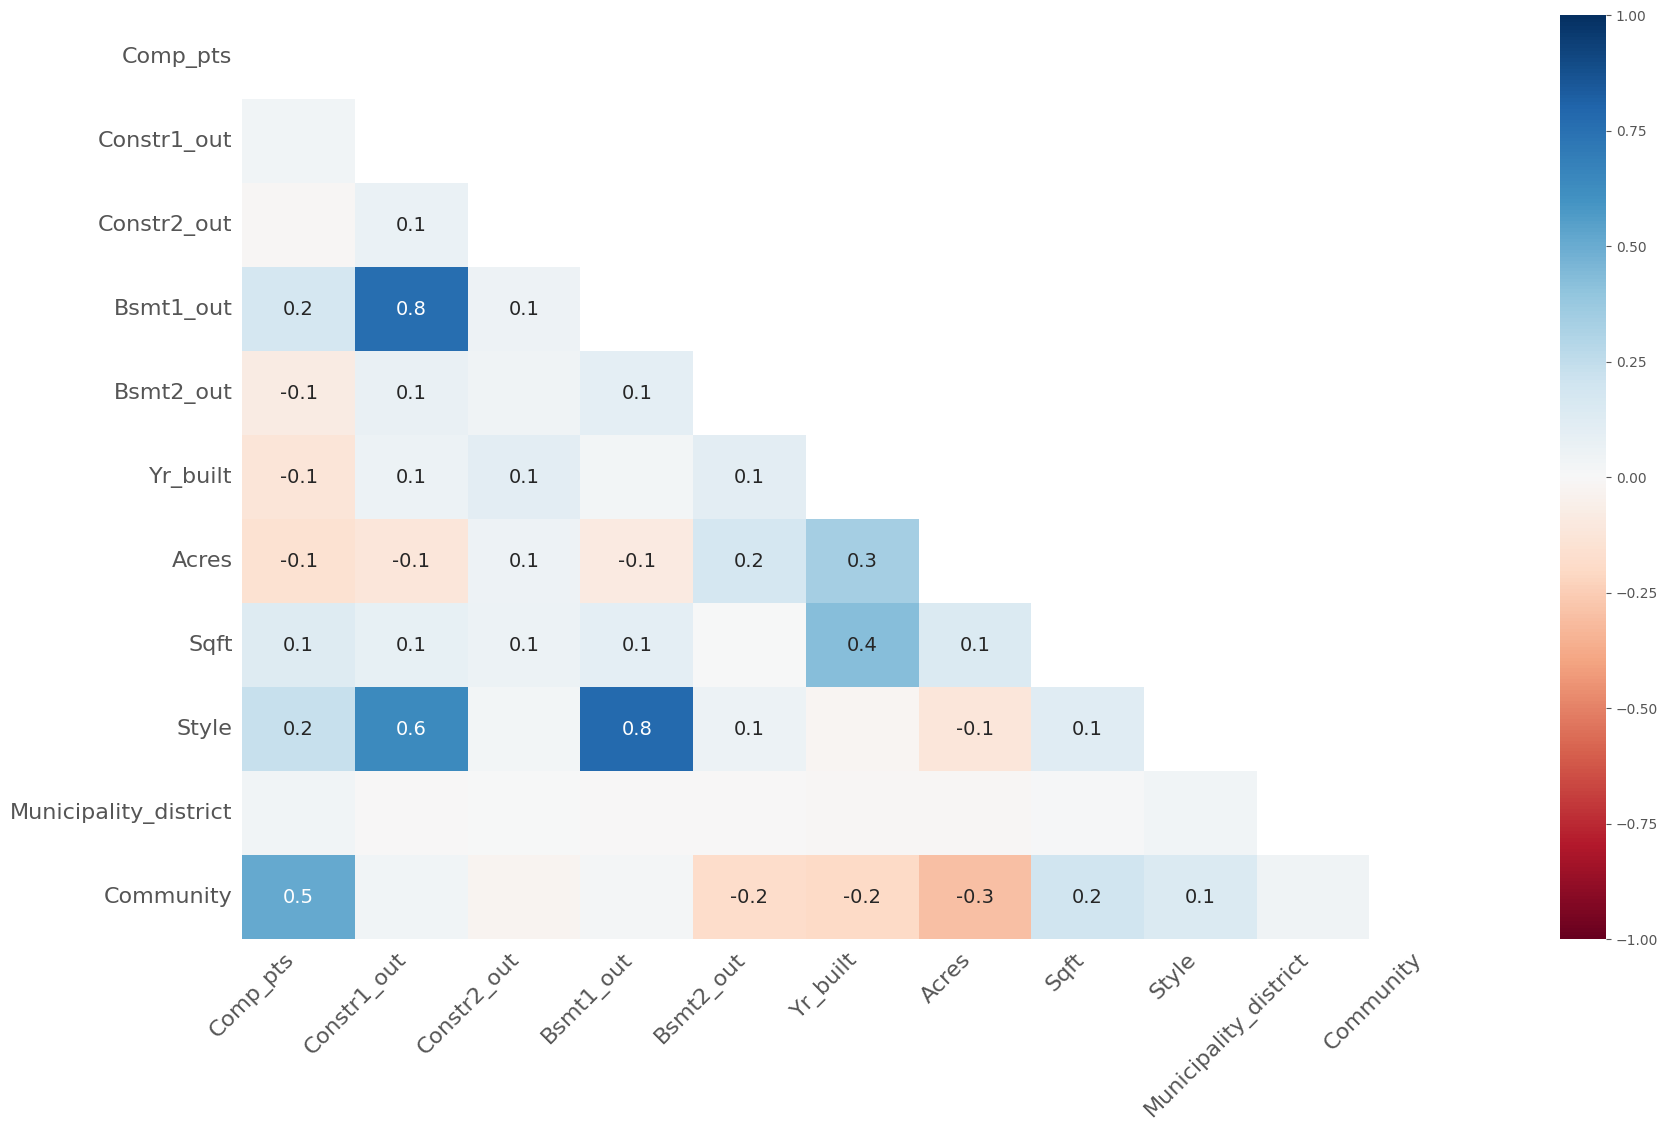

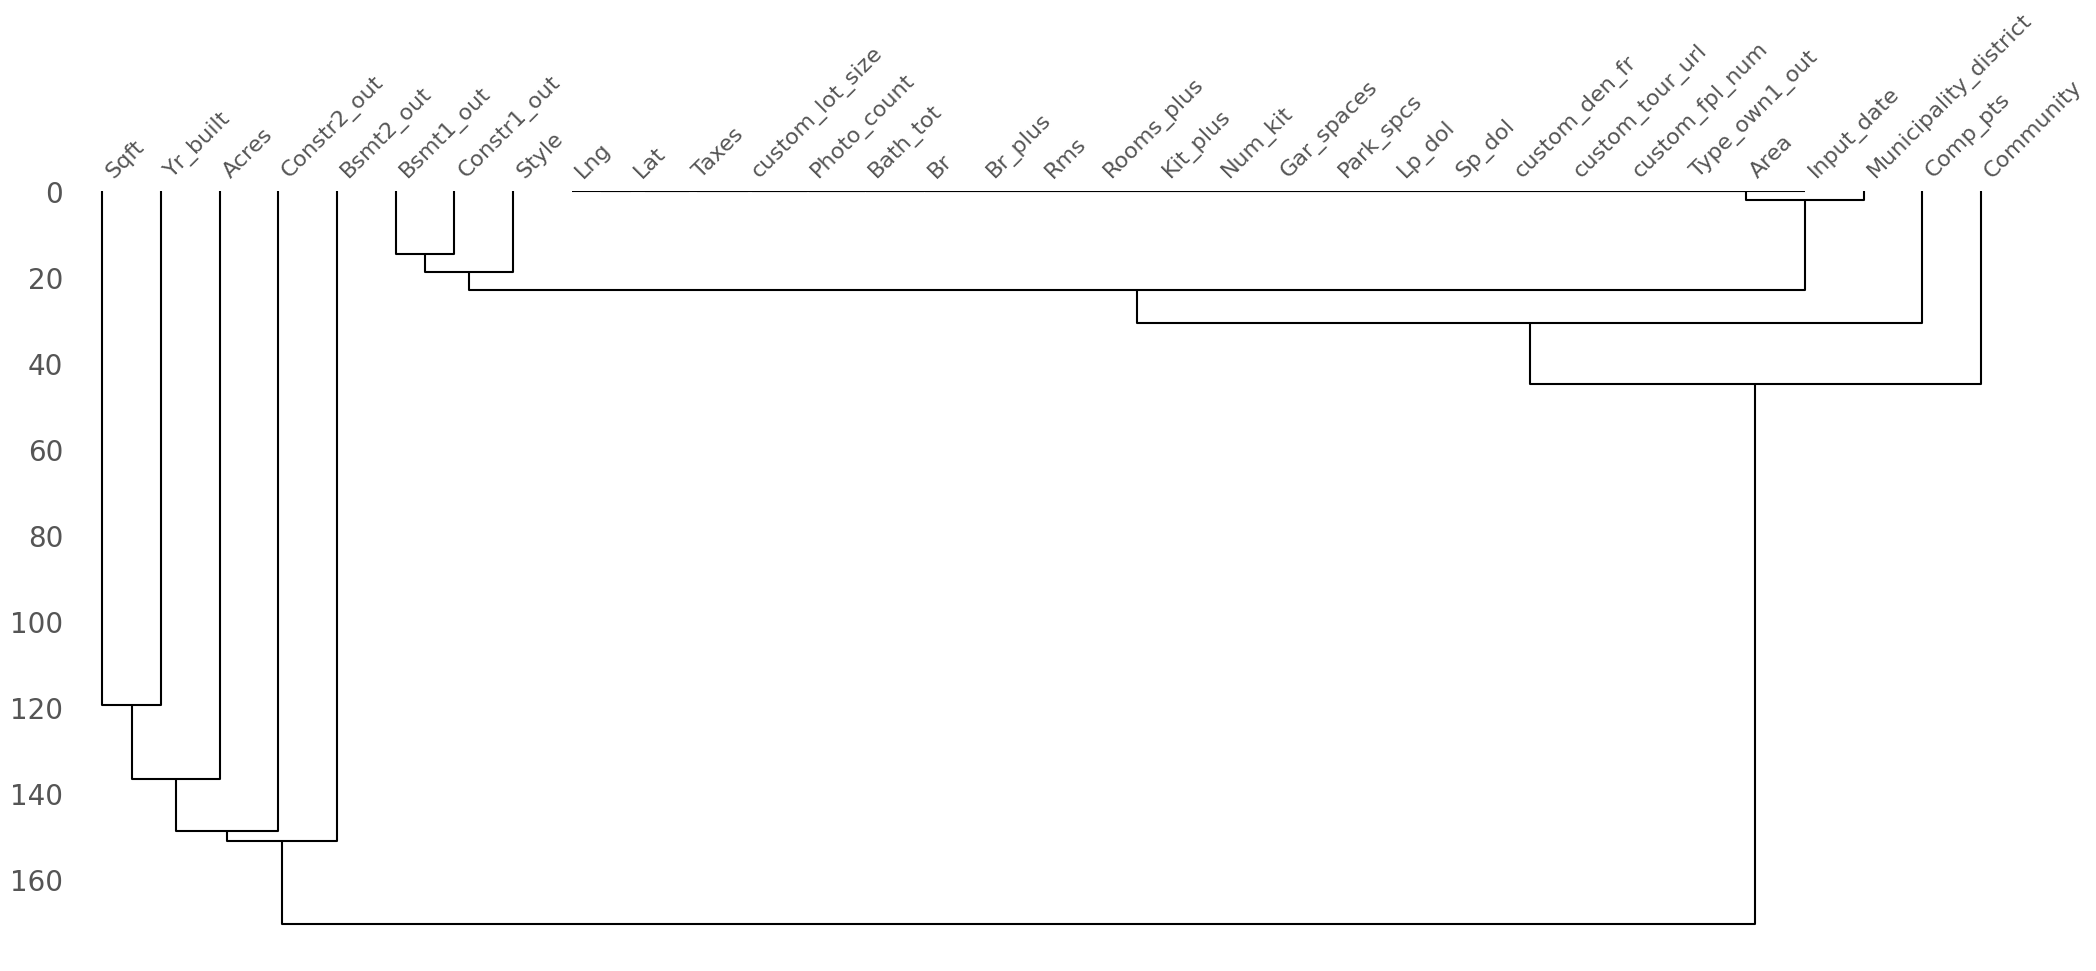

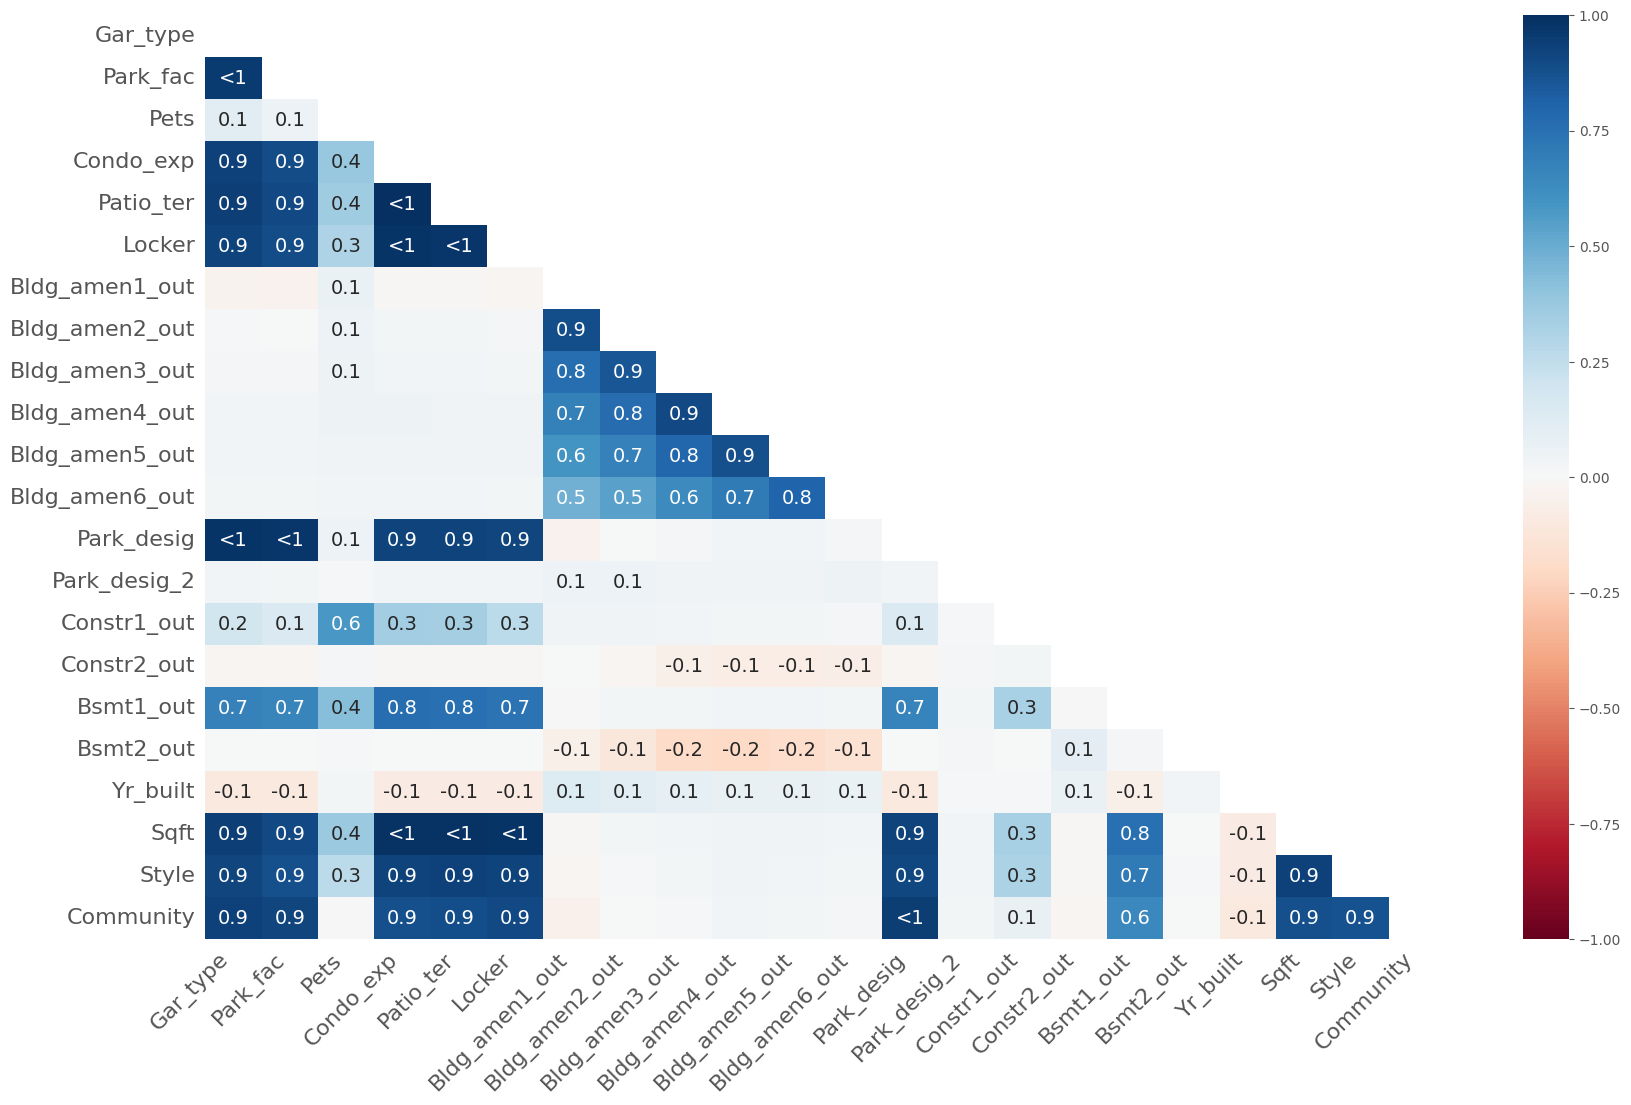

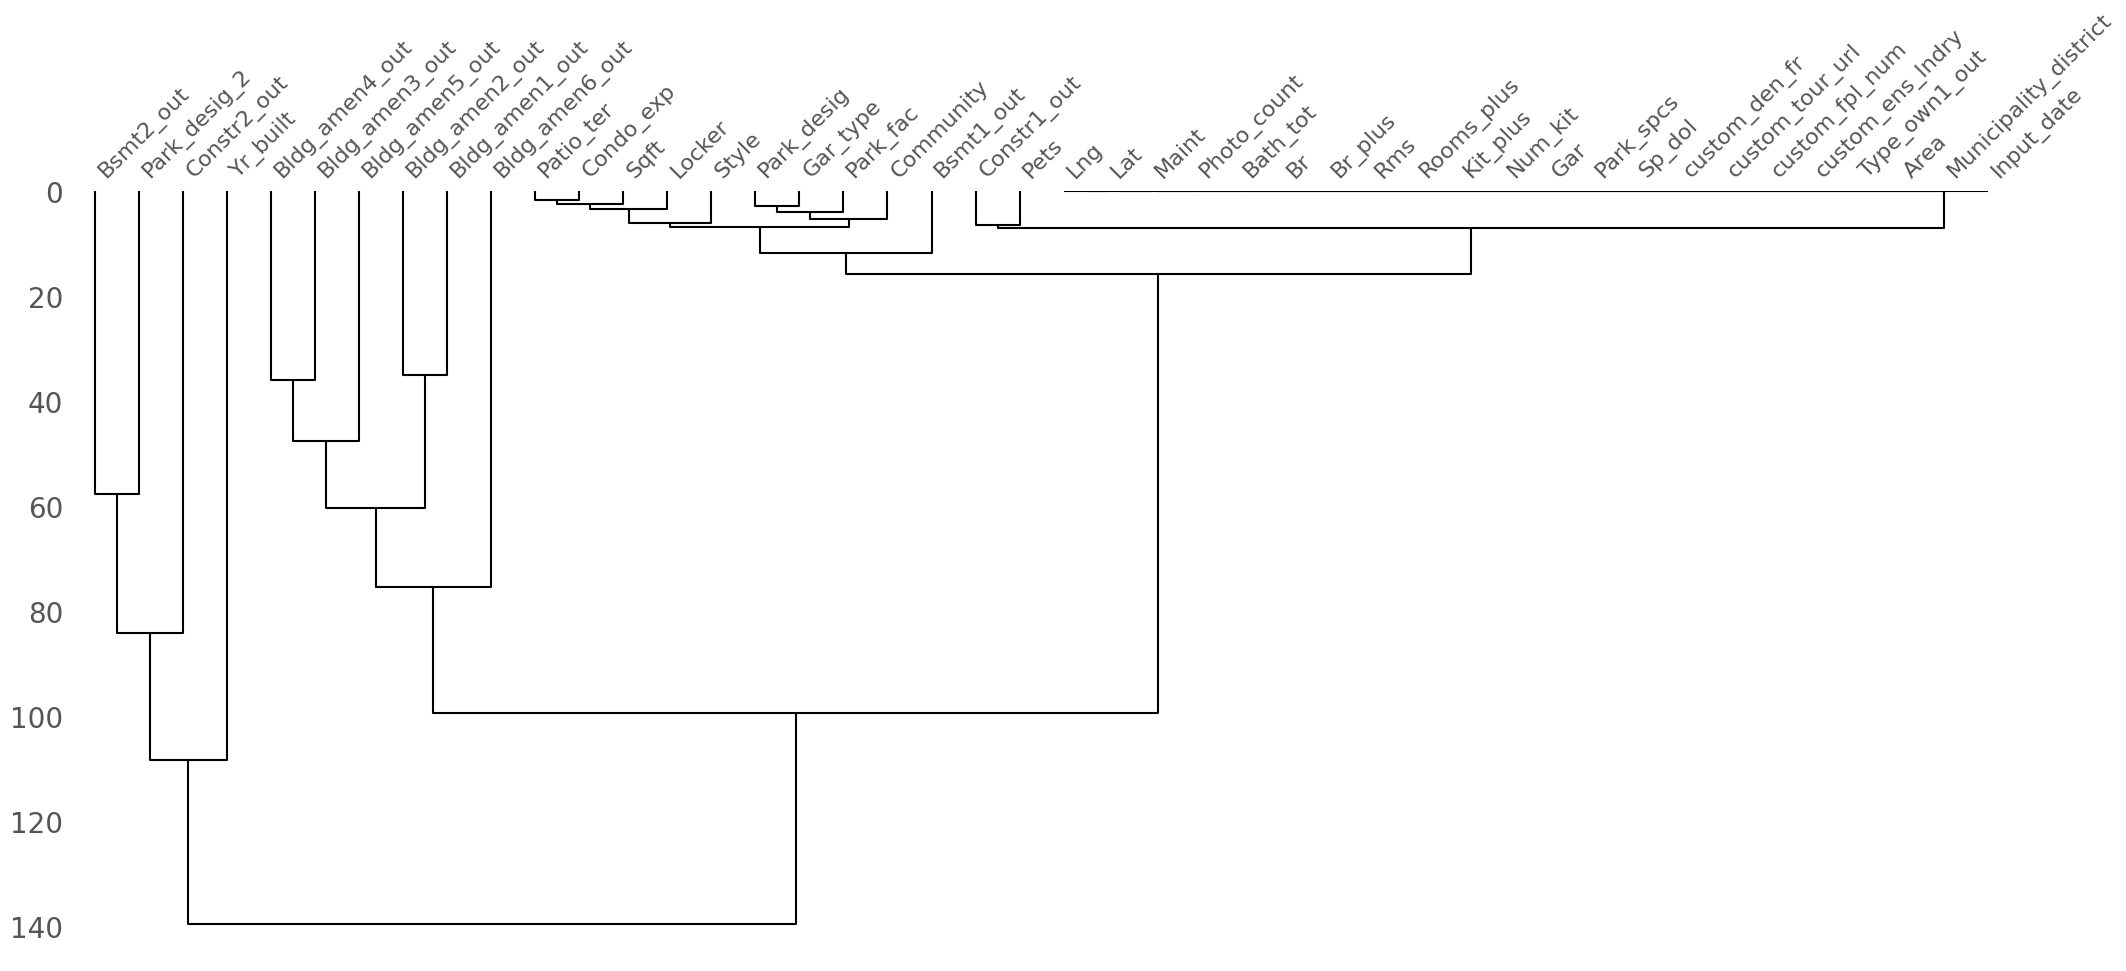

In [20]:
# https://github.com/ResidentMario/missingno
# Nullity correlation ranges from -1 (if one variable appears the other definitely does not) to 0 (variables appearing or not appearing have no effect on one another) to 1 (if one variable appears the other definitely also does).

msno.heatmap(data_res)
msno.dendrogram(data_res)
msno.heatmap(data_con)
msno.dendrogram(data_con)

## Correlation Analysis

C:\Users\Frank\AppData\Local\Temp\ipykernel_37772\2516444103.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatt = data_res[topFeatures].corr()
C:\Users\Frank\AppData\Local\Temp\ipykernel_37772\2516444103.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corrMatt = data_con[topFeatures].corr()


<Axes: >

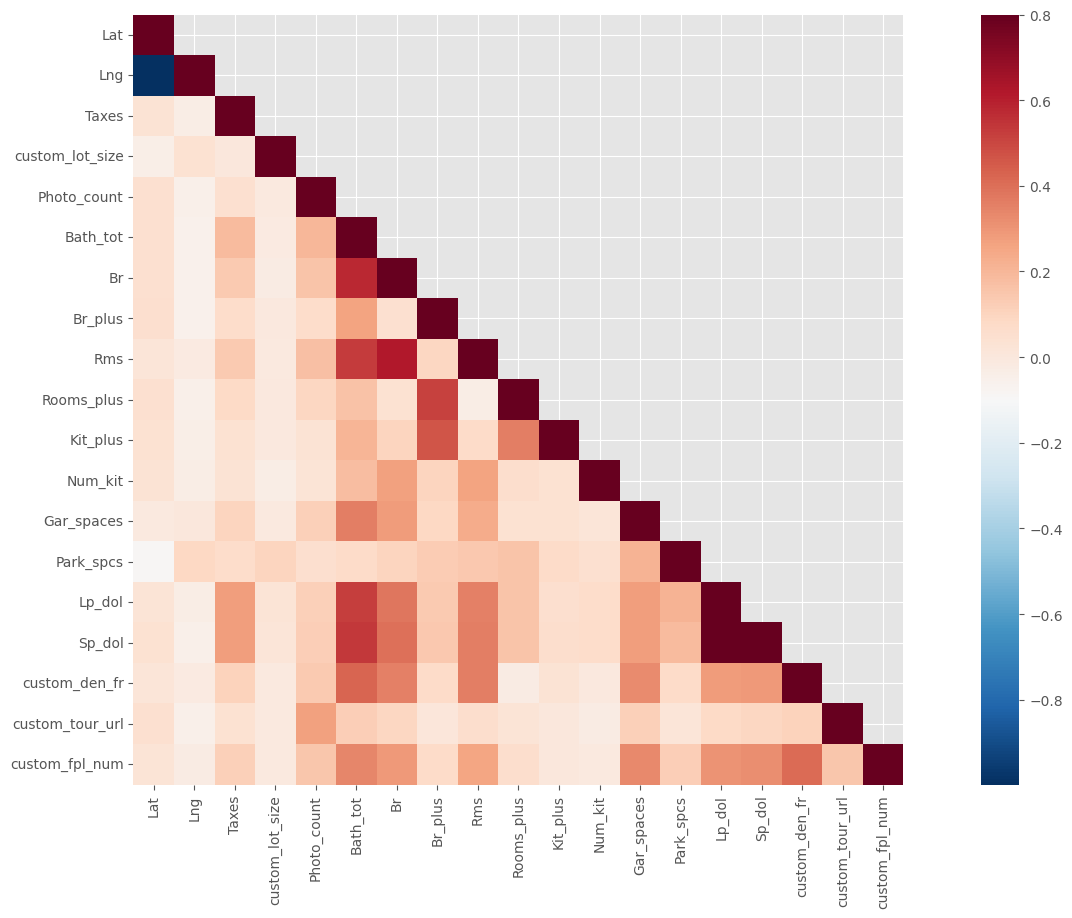

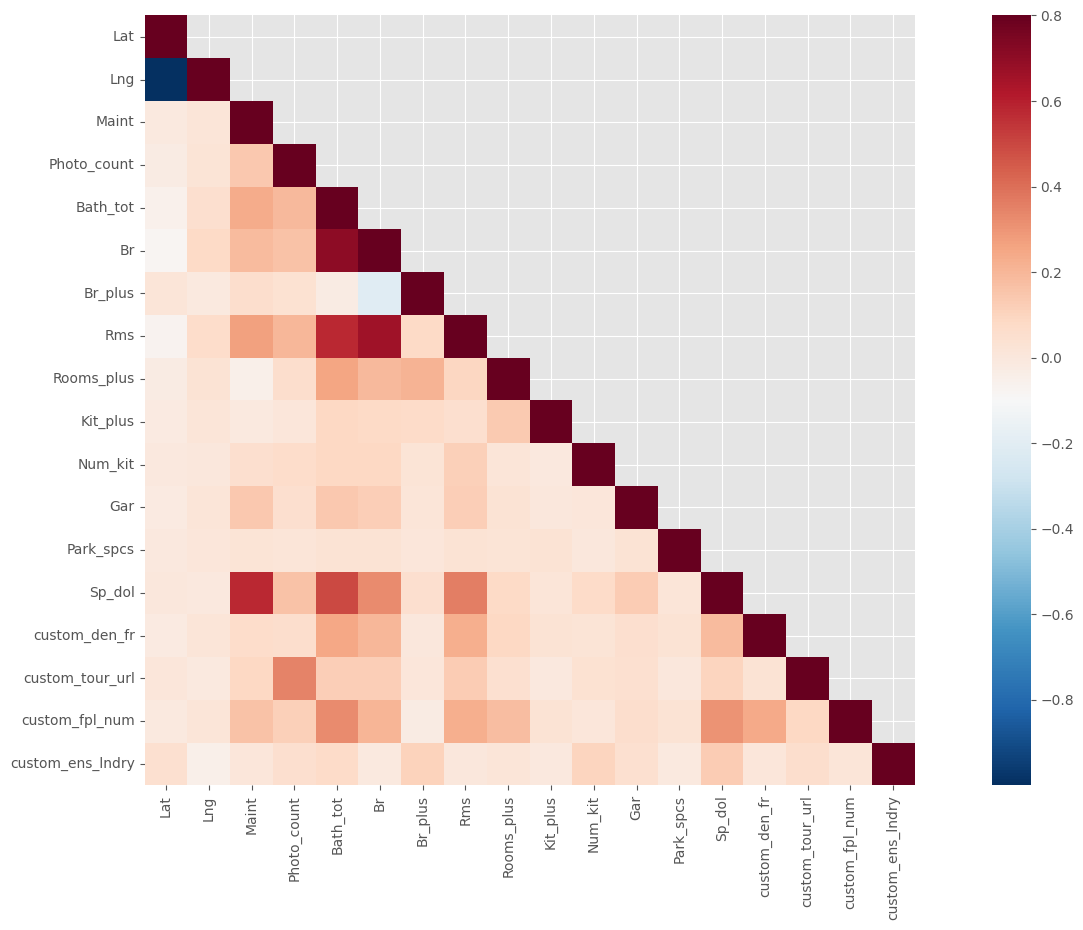

In [21]:
topFeatures = features_res[:20]
corrMatt = data_res[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True, cmap="RdBu_r")#, cmap="YlGnBu")




topFeatures = features_con[:20]
corrMatt = data_con[topFeatures].corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False
fig,ax= plt.subplots()
fig.set_size_inches(20,10)
sn.heatmap(corrMatt, mask=mask,vmax=.8, square=True, cmap="RdBu_r")#, cmap="YlGnBu")

## Save as Pickle File

In [22]:
# data_res.to_pickle("./2023_res_cleanup.pkl")
# data_con.to_pickle("./2023_con_cleanup.pkl")

# data_res.to_csv("./2023_res_cleanup.csv")
# data_con.to_csv("./2023_con_cleanup.csv")

# data_res_test_save, data_res_train_save = np.split(data_res, [int(.1*len(data_res))])
# data_con_test_save, data_con_train_save = np.split(data_con, [int(.1*len(data_con))])

# data_res_train_save.to_csv("./2023_res_cleanup_train.csv")
# data_res_test_save.to_csv("./2023_res_cleanup_test.csv")

# data_con_train_save.to_csv("./2023_con_cleanup_train.csv")
# data_con_test_save.to_csv("./2023_con_cleanup_test.csv")

# Base Model XGBoost

In [23]:
# How enable_cagegorical works: https://xgboost.readthedocs.io/en/stable/tutorials/categorical.html
from xgboost import XGBRegressor
from IPython.display import display
import dataframe_image as dfi

In [24]:
def split_data(data):
    data_test, data_validate, data_train = np.split(data, [int(.1*len(data)), int(.2*len(data))])

    data_test_x = data_test.drop("Sp_dol", axis=1)
    data_test_y = data_test["Sp_dol"]

    data_validate_x = data_validate.drop("Sp_dol", axis=1)
    data_validate_y = data_validate["Sp_dol"]

    data_train_x = data_train.drop("Sp_dol", axis=1)
    data_train_y = data_train["Sp_dol"]
    
    print("     all data:", data.shape)
    print("    test data:", data_test.shape)
    print("validate data:", data_validate.shape)
    print(   "train data:", data_train.shape)
    
    result = {
        "train": data_train,
        "train_x": data_train_x,
        "train_y": data_train_y,
        "validate": data_validate,
        "validate_x": data_validate_x,
        "validate_y": data_validate_y,
        "test": data_test,
        "test_x": data_test_x,
        "test_y": data_test_y,
    }
    
    return result

def xgboost_model(data, train_verbose=0):
    
    start_time = time.time()
    
    my_model = XGBRegressor(n_estimators=1000, learning_rate=0.05, n_jobs=4, device="cuda", eval_metric="mae", early_stopping_rounds=20, enable_categorical=True)
    my_model.fit(data["train_x"], data["train_y"], eval_set=[(data["validate_x"], data["validate_y"])], verbose=train_verbose)#,feature_weights=feature_weights)

    print(f"Train time: {time.time()-start_time:.2f} seconds")
    
    
    mae_history = my_model.evals_result()
    mae_data = mae_history["validation_0"]["mae"]
    plt.plot(range(1, len(mae_data) + 1), mae_data)
    plt.annotate('%0.2f' % mae_data[-1], xy=(1, mae_data[-1]), xytext=(8, 0), xycoords=('axes fraction', 'data'), textcoords='offset points')
    plt.xlabel('Epochs')
    plt.ylabel('Validation MAE')
    plt.show()
    
    
    return my_model


def predict_result(my_model, data, data_name, save_path):
    
    if data_name == "train":
        d_x = data["train_x"]
        d_y = data["train_y"]
    elif data_name == "validate":
        d_x = data["validate_x"]
        d_y = data["validate_y"]
    elif data_name == "test":
        d_x = data["test_x"]
        d_y = data["test_y"]
    else:
        print("data_name must be train, validate or test.")
        return
    
    pred = my_model.predict(d_x)

    output = pd.DataFrame({'Ml_num': d_x.index,
                           'predict': pred, "actual":d_y, "diff": pred - d_y, "diff_perc": np.abs(pred - d_y)/d_y})
    output.to_csv(save_path, index=True)
    
    return output


def display_worst_prediction(my_model, data, data_name, k=10):
    
    
    if data_name == "train":
        d_x = data["train_x"]
        d_y = data["train_y"]
    elif data_name == "validate":
        d_x = data["validate_x"]
        d_y = data["validate_y"]
    elif data_name == "test":
        d_x = data["test_x"]
        d_y = data["test_y"]
    else:
        print("data_name must be train, validate or test.")
        return
    
    pred = my_model.predict(d_x)
    pred_y = d_y

    pred = pd.DataFrame({"pred":pred, "Ml_num":d_x.index, "pred_y":pred_y})
    pred.set_index("Ml_num", inplace=True)
    
    pred["diff"] = np.abs(pred["pred"]-pred["pred_y"]) / pred["pred_y"]
    display(pred[["pred", "pred_y", "diff"]].sort_values(by=["diff"],ascending=False).head(k)
            .rename(columns={"pred": "Prediction", "pred_y": "Sale Price", "diff":"Different Percentage"})
            .style.format({"Prediction":"{:,.0f}", "Sale Price":"{:,.0f}", "Different Percentage":"{:,.2%}"})
            .set_table_styles([{
                 'selector': 'caption',
                 'props': 'font-weight:bold;font-size:1.25em;'
             }], overwrite=False)
            .set_caption(f"Worst Predict Result of Listings<br>({data_name} set)"))


    print("Total predicted:", pred.shape)
    print("Total predicted with difference > 0.5:", pred[pred["diff"]>0.5].shape)
    
    
def display_predict_result(my_model, data, data_name, group_by="Area", sort_by="Homes", ascending=False):
    
    if data_name == "train":
        d_x = data["train_x"]
        d_y = data["train_y"]
    elif data_name == "validate":
        d_x = data["validate_x"]
        d_y = data["validate_y"]
    elif data_name == "test":
        d_x = data["test_x"]
        d_y = data["test_y"]
    else:
        print("data_name must be train, validate or test.")
        return
    
    pred = my_model.predict(d_x)
    pred_y = d_y

    # group_by = "Area" #"Area" # "Municipality_district" # "S_r"
    # sort_by = "Homes" # "Municipality_district" # "Homes"
    # ascending = False

    pred = pd.DataFrame({"pred":pred, "Ml_num":d_x.index, "pred_y":pred_y})
    pred = pd.concat([pred, d_x[[group_by]]], axis=1, join='inner')
    pred.set_index("Ml_num", inplace=True)

    
    def calculation(x):
        perc = np.abs(x["pred"] - x["pred_y"])/x["pred_y"]
        median = perc.median()
        count_5 = perc[perc <= 0.05].count() / x["pred"].size if x["pred"].size else 0
        count_10 = perc[perc <= 0.10].count() / x["pred"].size if x["pred"].size else 0
        count_20 = perc[perc <= 0.20].count() / x["pred"].size if x["pred"].size else 0

        # print(x.shape) <= (15, 3)
        # print(x.size) <= 45
        # print(x.size.astype(int)) <= 45

        res = {'Median Error': median, 'Within 5% of Sales Price': count_5, 'Within 10% of Sales Price': count_10, 'Within 20% of Sales Price': count_20, "Homes":x["pred"].size}
        return pd.Series(res, index=res.keys())


    # TODO: why groupby contains empty dataframe, a workaround right now is prevent zero division in calculation()
    result = pred.groupby([group_by]).apply(calculation)
    result.loc["All Areas"] = calculation(pred)

    result = result.sort_values(by=sort_by, ascending=ascending)
    result_style = result.style.format({'Median Error': "{:.2%}",'Within 5% of Sales Price': "{:.2%}",'Within 10% of Sales Price': "{:.2%}",'Within 20% of Sales Price': "{:.2%}",'Homes': "{:,.0f}"})
    display(result_style)
    result[['Median Error','Within 5% of Sales Price','Within 10% of Sales Price','Within 20% of Sales Price']] = result[['Median Error','Within 5% of Sales Price','Within 10% of Sales Price','Within 20% of Sales Price']].applymap('{:.2%}'.format)
    result['Homes'] = result['Homes'].apply('{:,.0f}'.format)
    # result.dfi.export(f"2023_res_validate_result.png")
    
    
def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    # for i in range(shap_values.values.shape[1]):
    #     importances.append(np.mean(np.abs(shap_values.values[:, i])))
    for i in range(shap_values.shape[1]):
        importances.append(np.mean(np.abs(shap_values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")

## Residential

     all data: (50026, 33)
    test data: (5002, 33)
validate data: (5003, 33)
train data: (40021, 33)
Train time: 3.49 seconds


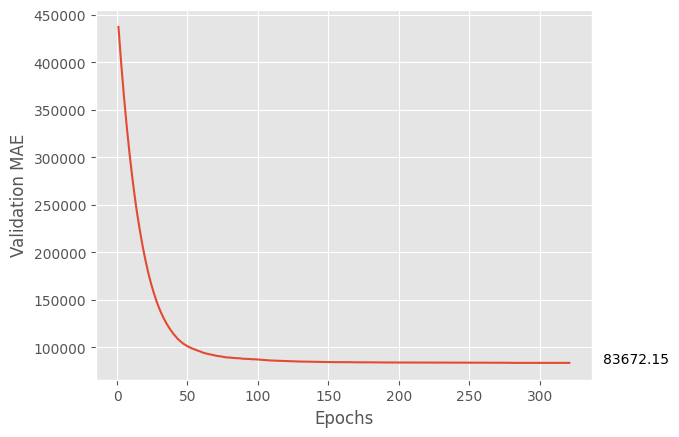

C:\Users\Frank\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:160: UserWarning: [05:58:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\common\error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


,predict,actual,diff,diff_perc
count,5003.00,5003.00,5003.00,5003.00
mean,1321337.62,1290462.90,30874.64,0.06
std,776780.12,863440.17,319397.23,0.07
min,184959.62,80000.00,-16499016.00,0.00
25%,915509.72,880000.00,-7421.19,0.02
50%,1148989.25,1110000.00,33558.62,0.04
75%,1477972.88,1450000.00,77103.25,0.08
max,15712954.00,25000000.00,5549598.00,1.35


In [25]:
split_data_res = split_data(data_res)
model_res = xgboost_model(split_data_res, train_verbose=0)
result_res = predict_result(model_res, split_data_res, "validate", "2023_res_validate_result.csv")


pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
result_res.describe()

In [26]:
display_worst_prediction(model_res, split_data_res, "validate")

,Prediction,Sale Price,Different Percentage
Ml_num,,,
S6719890,"187,888","80,000",134.86%
S7003572,"189,794","82,000",131.46%
S7034508,"1,058,208","475,000",122.78%
S6205708,"201,382","90,500",122.52%
N7231740,"10,349,598","4,800,000",115.62%
C6756384,"10,708,152","6,125,000",74.83%
N7203060,"227,239","135,000",68.33%
W7047436,"8,500,984","25,000,000",66.00%
C7015204,"6,179,596","14,800,000",58.25%


Total predicted: (5003, 3)
Total predicted with difference > 0.5: (11, 3)


In [27]:
display_predict_result(model_res, split_data_res, "validate")

,Median Error,Within 5% of Sales Price,Within 10% of Sales Price,Within 20% of Sales Price,Homes
Area,,,,,
All Areas,4.49%,54.43%,83.99%,97.70%,"5,003"
Toronto,6.16%,42.00%,73.32%,95.75%,"1,293"
York,4.56%,52.82%,83.18%,97.63%,886
Peel,3.89%,61.37%,91.23%,99.41%,844
Durham,4.94%,50.68%,85.25%,98.88%,807
Simcoe,2.97%,71.88%,91.21%,98.08%,626
Halton,3.75%,60.91%,89.81%,98.13%,481
Dufferin,3.32%,63.64%,84.85%,93.94%,66


In [28]:
display_predict_result(model_res, split_data_res, "validate", group_by="Municipality_district", sort_by="Homes", ascending=False)

,Median Error,Within 5% of Sales Price,Within 10% of Sales Price,Within 20% of Sales Price,Homes
Municipality_district,,,,,
All Areas,4.49%,54.43%,83.99%,97.70%,"5,003"
Brampton,3.78%,65.34%,93.91%,99.77%,427
Mississauga,4.25%,56.00%,88.29%,99.43%,350
Markham,5.57%,47.09%,79.82%,97.31%,223
Vaughan,3.83%,63.55%,85.71%,97.04%,203
Oshawa,4.56%,52.24%,81.09%,98.01%,201
Whitby,4.93%,50.29%,84.80%,100.00%,171
Barrie,2.76%,80.24%,94.61%,99.40%,167
Oakville,4.31%,57.14%,87.66%,98.05%,154


In [29]:
# # https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
# https://github.com/slundberg/shap/issues/2662
# https://discuss.xgboost.ai/t/xgboost-python-predict-vs-predict-pred-contribs-true/1596

import xgboost as xgb
from tqdm.notebook import tqdm as tqdm
import shap
from scipy.special import softmax

shap_values_res = model_res._Booster.predict(xgb.DMatrix(split_data_res["validate_x"], enable_categorical=True), pred_contribs=True)
# Also remove the last column because it contains the bias term.
shap_values_res = shap_values_res[:, :-1]

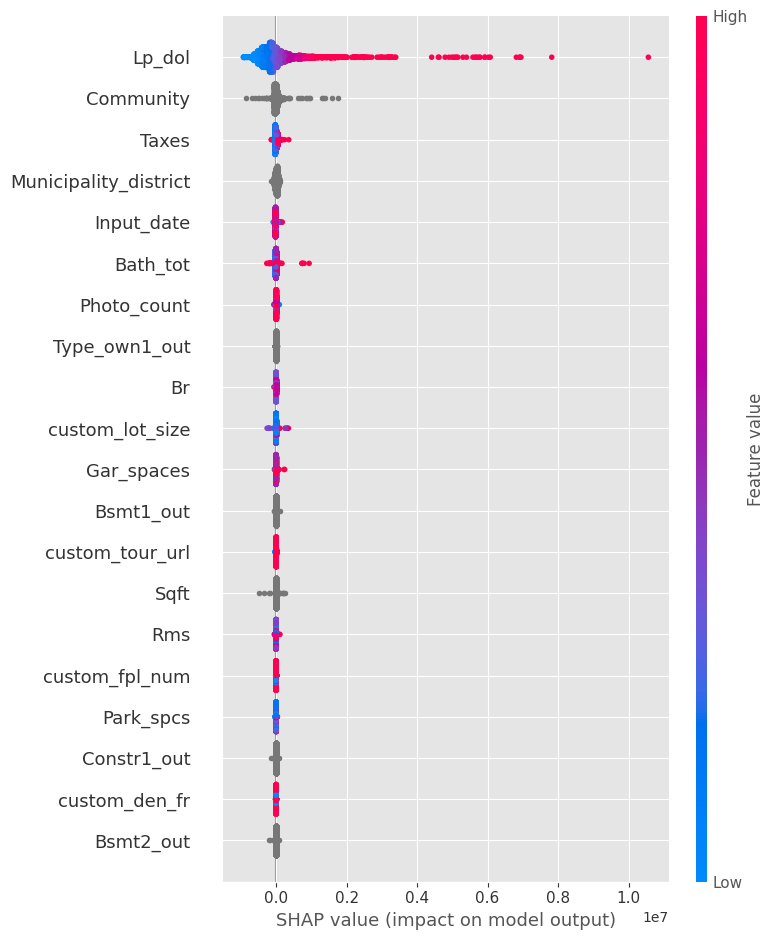

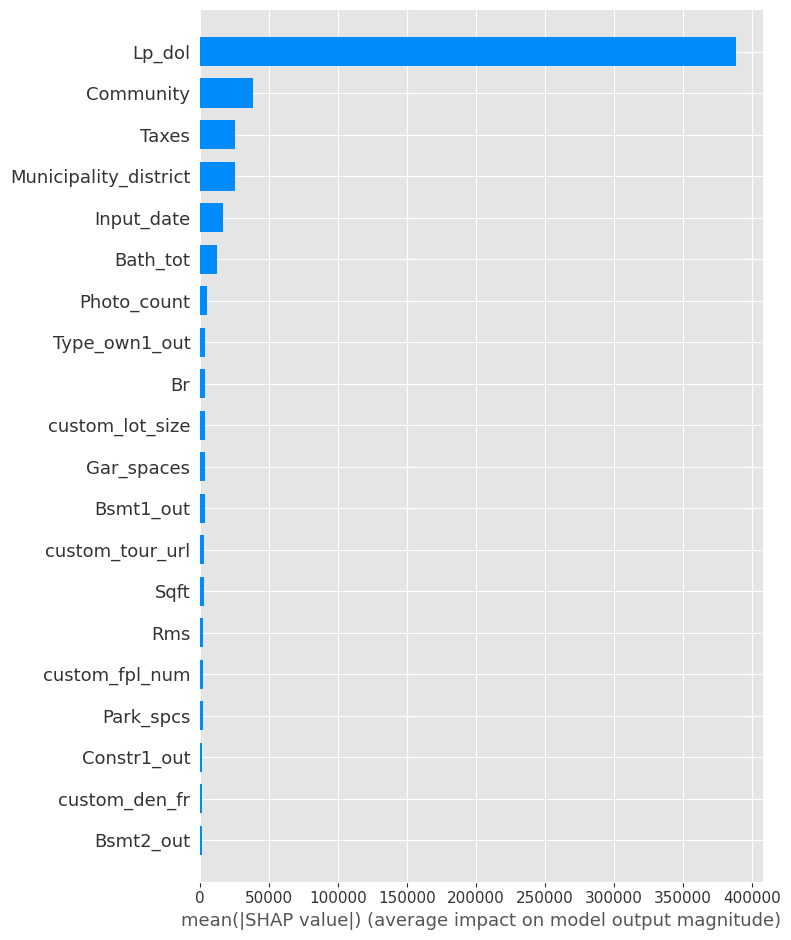

Lp_dol -> 388129.7812 (softmax = 1.0000)
Municipality_district -> 38363.7344 (softmax = 0.0000)
Taxes -> 25421.9492 (softmax = 0.0000)
Area -> 25133.9590 (softmax = 0.0000)
Community -> 16378.2480 (softmax = 0.0000)
Bath_tot -> 12467.0430 (softmax = 0.0000)
Photo_count -> 5227.1455 (softmax = 0.0000)
Style -> 3872.2046 (softmax = 0.0000)
Br -> 3655.7471 (softmax = 0.0000)
custom_lot_size -> 3592.4578 (softmax = 0.0000)
Gar_spaces -> 3578.3435 (softmax = 0.0000)
Constr2_out -> 3240.1694 (softmax = 0.0000)
custom_den_fr -> 3049.0417 (softmax = 0.0000)
Acres -> 2973.6646 (softmax = 0.0000)
Rms -> 2321.7744 (softmax = 0.0000)
custom_tour_url -> 2264.0327 (softmax = 0.0000)
Park_spcs -> 1799.5129 (softmax = 0.0000)
Comp_pts -> 1605.2572 (softmax = 0.0000)
Sp_dol -> 1596.6753 (softmax = 0.0000)
Bsmt1_out -> 1583.4617 (softmax = 0.0000)
Bsmt2_out -> 1518.2314 (softmax = 0.0000)
Constr1_out -> 1502.6006 (softmax = 0.0000)
Sqft -> 1452.0979 (softmax = 0.0000)
Br_plus -> 1304.9712 (softmax = 0.0

In [30]:
# For text features, both engineered and generated by word2vec, tests were conducted to show that they bring significant contribution to prediction results accuracy. All text features were retained in the final model.
# Grey is for NaN feature values (there are never NaN SHAP values), but I would be surprised if your whole dataset is NaN.

# https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/#:~:text=Mean%20absolute%20SHAP%20values%20are,we're%20interested%20in).

shap.summary_plot(shap_values_res, split_data_res["validate_x"], max_display=20)
shap.summary_plot(shap_values_res, split_data_res["validate_x"], plot_type='bar', max_display=20)
print_feature_importances_shap_values(shap_values_res, features_res)

## Condo

     all data: (26171, 44)
    test data: (2617, 44)
validate data: (2617, 44)
train data: (20937, 44)
Train time: 1.89 seconds


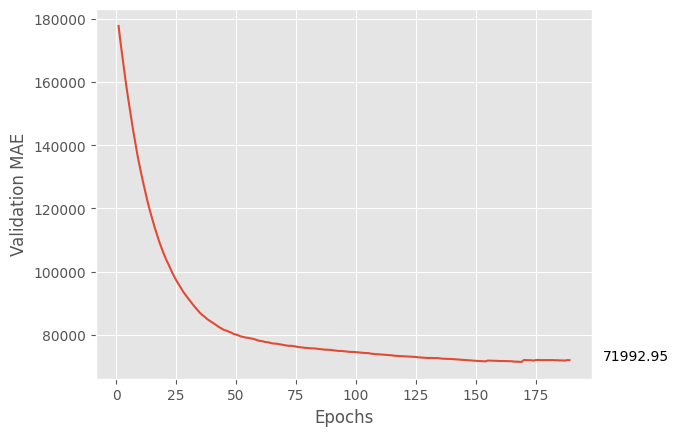

,predict,actual,diff,diff_perc
count,2617.00,2617.00,2617.00,2617.00
mean,750875.50,726330.82,24544.66,0.11
std,284096.78,319528.72,124709.52,0.80
min,39782.75,3800.00,-2546797.50,0.00
25%,597020.06,566000.00,-13019.88,0.03
50%,686785.19,660000.00,26367.50,0.07
75%,822497.62,800000.00,67856.06,0.13
max,4748202.50,7295000.00,988348.75,39.91


In [31]:
split_data_con = split_data(data_con)
model_con = xgboost_model(split_data_con, train_verbose=0)
result_con = predict_result(model_con, split_data_con, "validate", "2023_con_validate_result.csv")


pd.set_option('display.float_format', '{:.2f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
result_con.describe()

In [32]:
display_worst_prediction(model_con, split_data_con, "validate")

,Prediction,Sale Price,Different Percentage
Ml_num,,,
C6157924,"606,472","14,825","3,990.87%"
C6146820,"39,783","3,800",946.91%
C7020222,"1,289,202","658,800",95.69%
E7000696,"95,370","50,000",90.74%
W7232976,"1,931,862","1,050,000",83.99%
C7033838,"2,388,349","1,400,000",70.60%
N7031478,"1,209,475","709,000",70.59%
C7015104,"916,527","550,000",66.64%
E6752262,"543,146","330,000",64.59%


Total predicted: (2617, 3)
Total predicted with difference > 0.5: (18, 3)


In [33]:
display_predict_result(model_con, split_data_con, "validate")

,Median Error,Within 5% of Sales Price,Within 10% of Sales Price,Within 20% of Sales Price,Homes
Area,,,,,
All Areas,7.04%,37.87%,64.50%,90.10%,"2,617"
Toronto,7.44%,36.33%,62.69%,89.44%,"1,525"
Peel,5.95%,42.78%,71.10%,93.77%,353
York,6.62%,37.84%,69.97%,92.19%,333
Halton,7.45%,39.20%,63.32%,90.45%,199
Durham,6.47%,45.31%,63.28%,89.84%,128
Simcoe,8.36%,32.39%,54.93%,78.87%,71
Dufferin,15.60%,12.50%,25.00%,62.50%,8


In [34]:
display_predict_result(model_con, split_data_con, "validate", group_by="Municipality_district", sort_by="Homes", ascending=False)

,Median Error,Within 5% of Sales Price,Within 10% of Sales Price,Within 20% of Sales Price,Homes
Municipality_district,,,,,
All Areas,7.04%,37.87%,64.50%,90.10%,"2,617"
Toronto C01,9.17%,28.90%,54.87%,88.96%,308
Mississauga,6.23%,41.20%,70.77%,93.66%,284
Toronto C08,7.66%,34.68%,61.27%,84.39%,173
Vaughan,5.79%,40.83%,77.50%,95.00%,120
Markham,6.35%,38.18%,69.09%,91.82%,110
Burlington,7.61%,39.78%,66.67%,93.55%,93
Toronto C15,5.71%,47.83%,71.74%,90.22%,92
Toronto W08,7.78%,32.22%,64.44%,91.11%,90


In [35]:
# # https://towardsdatascience.com/using-shap-values-to-explain-how-your-machine-learning-model-works-732b3f40e137
# https://github.com/slundberg/shap/issues/2662
# https://discuss.xgboost.ai/t/xgboost-python-predict-vs-predict-pred-contribs-true/1596

import xgboost as xgb
from tqdm.notebook import tqdm as tqdm
import shap
from scipy.special import softmax

shap_values_con = model_con._Booster.predict(xgb.DMatrix(split_data_con["validate_x"], enable_categorical=True), pred_contribs=True)
# Also remove the last column because it contains the bias term.
shap_values_con = shap_values_con[:, :-1]

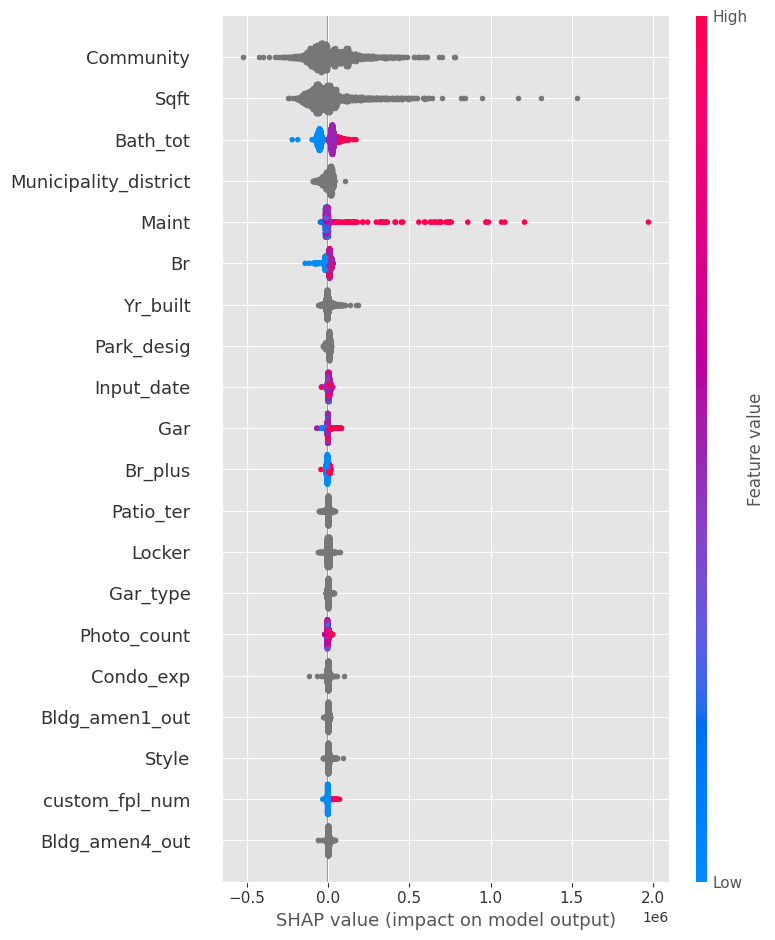

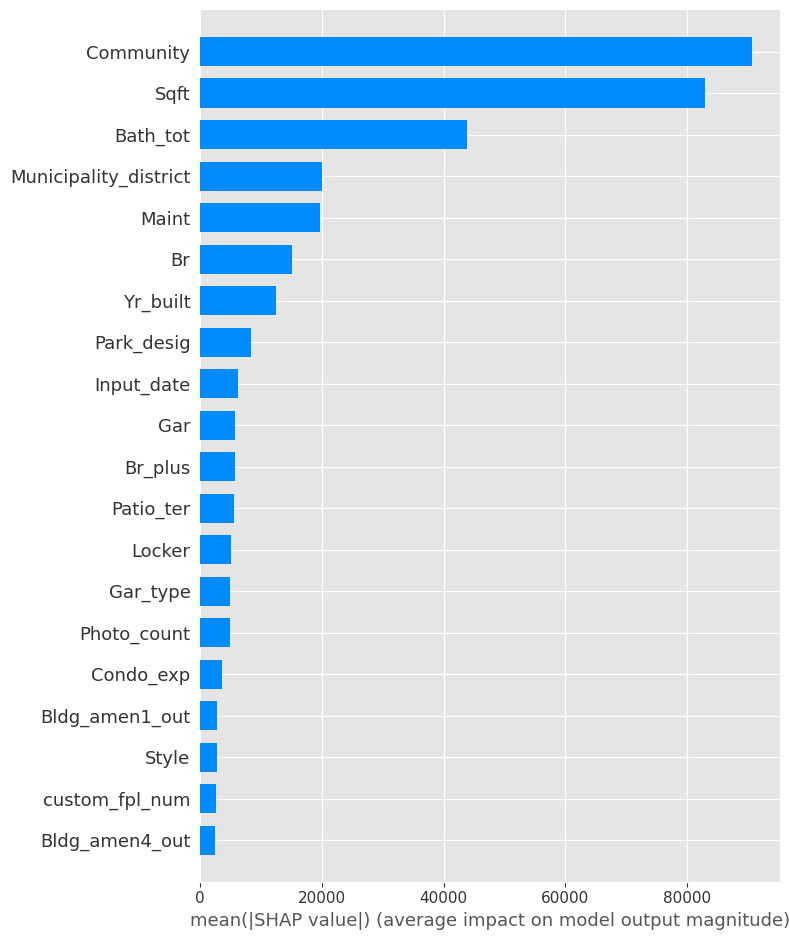

Municipality_district -> 90704.4531 (softmax = 1.0000)
Yr_built -> 82948.0938 (softmax = 0.0000)
Bath_tot -> 43909.8984 (softmax = 0.0000)
Area -> 20083.2715 (softmax = 0.0000)
Maint -> 19652.6113 (softmax = 0.0000)
Br -> 15093.5449 (softmax = 0.0000)
Bsmt2_out -> 12449.6924 (softmax = 0.0000)
Bldg_amen6_out -> 8296.3311 (softmax = 0.0000)
Community -> 6168.3550 (softmax = 0.0000)
Gar -> 5801.0371 (softmax = 0.0000)
Br_plus -> 5792.7109 (softmax = 0.0000)
Condo_exp -> 5599.8970 (softmax = 0.0000)
Patio_ter -> 5077.6226 (softmax = 0.0000)
custom_ens_lndry -> 4909.5063 (softmax = 0.0000)
Photo_count -> 4832.5088 (softmax = 0.0000)
Pets -> 3609.7158 (softmax = 0.0000)
Locker -> 2801.5039 (softmax = 0.0000)
Sqft -> 2757.3752 (softmax = 0.0000)
custom_tour_url -> 2565.4854 (softmax = 0.0000)
Bldg_amen3_out -> 2476.1189 (softmax = 0.0000)
Park_desig_2 -> 2233.2490 (softmax = 0.0000)
Bldg_amen2_out -> 2053.2461 (softmax = 0.0000)
custom_fpl_num -> 1995.2533 (softmax = 0.0000)
Bldg_amen1_out -

In [36]:
# For text features, both engineered and generated by word2vec, tests were conducted to show that they bring significant contribution to prediction results accuracy. All text features were retained in the final model.
# Grey is for NaN feature values (there are never NaN SHAP values), but I would be surprised if your whole dataset is NaN.

# https://www.aidancooper.co.uk/a-non-technical-guide-to-interpreting-shap-analyses/#:~:text=Mean%20absolute%20SHAP%20values%20are,we're%20interested%20in).

shap.summary_plot(shap_values_con, split_data_con["validate_x"])
shap.summary_plot(shap_values_con, split_data_con["validate_x"], plot_type='bar')
print_feature_importances_shap_values(shap_values_con, features_con)